<a href="https://colab.research.google.com/github/kishore-n-george/telecom-churn/blob/main/telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
## Objectives
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

Recommend strategies to manage customer churn based on your observations.



Re-Usable Functions

In [441]:
def calculate_metrics(train,pred):
  """ Calculates important metrics for a given train and predictions"""
  metrics=[]
  r2 = r2_score(train, pred)
  metrics.append(r2)
  print("R2 Score is:", r2)
  rss = np.sum(np.square(train - pred))
  metrics.append(rss)
  print("RSS is ", rss)
  mse = mean_squared_error(train, pred)
  metrics.append(mse)
  print("MSE is: ", mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  metrics.append(rmse)
  print("RMSE is: ", rmse)
  return metrics

def run_cross_validation():
  """ Runs Cross validation for Ridge"""
  params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                      2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

  ridge = Ridge()
  # cross validation
  ridgeCV = GridSearchCV(estimator = ridge, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error',  
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1, n_jobs=-1)            
  ridgeCV.fit(X_train, y_train) 

  print(ridgeCV.best_params_)
  return ridgeCV

def do_residual_analysis(y_train, y_train_pred):
  """Does residual analysis and plots residuals"""
  y_res = y_train - y_train_pred
  #y_res
  data = pd.DataFrame({"res":y_res})
  plt.scatter( y_train_pred , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel("Predictions")
  plt.ylabel("Residual")
  plt.show()

# Distribution of errors
  p = sns.distplot(y_res,kde=True)

  p = plt.title('Normality of error terms/residuals')
  plt.xlabel("Residuals")
  plt.show()

def print_metrics(ridge_metrics, lasso_metrics, col1, col2):
  """Print metrics in comparable tabular format"""
  ## Setting float display options
  pd.options.display.float_format = "{:,.2f}".format
  # Creating a table which contain all the metrics
  lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                        'MSE (Train)', 'RMSE (Train)', 'R2 Score (Test)','RSS (Test)',
                        'MSE (Test)', 'RMSE (Test)'],
              col1 : ridge_metrics,
              col2 : lasso_metrics }

  final_metric = pd.DataFrame(lr_table, columns = ['Metric', col1,col2] )
  final_metric.set_index('Metric')
  print(final_metric)

# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [442]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [443]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data

In [444]:
telecom = pd.read_csv("train.csv")

In [445]:
# Check the head of the dataset
telecom.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...          0.0          0.0        NaN        NaN        NaN   
1  122.787  ...          0.0          0.0        NaN        1.0        NaN   
2  103.176  ...          0.0          0.0        NaN        NaN        NaN   
3  205.260  ...          0.0          0.0        NaN        NaN        NaN   
4  128.191  ...          1.0          0.0        1.0        1.0        1.0   

      aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958.0         0.0         0.0         0.0                0.0  
1   710.0         0.0         0.0         0.0                0.0  
2   882.0         0.0         0.0         0.0                0.0  
3   982.0         0.0         0.0         0.0                0.0  
4   647.0         0.0         0.0         0.0                0.0  

[5 rows x 172 columns]

Inspect the various aspects of the dataframe

In [446]:
telecom.shape
# Inference - 34897 Rows, 172 Columns

(34897, 172)

In [447]:
telecom.info(verbose=True, show_counts=True)
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

Check for duplicates

In [448]:
# check for duplicate rows based on id
any_duplicates=telecom.duplicated(['id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [449]:
# remove empty columns
telecom = telecom.dropna(axis = 1, how = 'all')
telecom.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

Drop rows with NA

In [450]:
#drop all the rows with only nan values
telecom = telecom.dropna(axis = 0, how = 'all')
telecom.info()
# no of rows remains 34897

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Columns: 172 entries, id to churn_probability
dtypes: float64(152), int64(11), object(9)
memory usage: 45.8+ MB


Data Imputation
- Dropping columns with high percentage of NA removes some important columns
- So, impute before dropping columns

In [451]:
rech_col = [col for col in telecom.columns if 'rech' in col and 'date' not in col]
print(rech_col)

for col in rech_col:
  print(col)
  print('Before Cleaning')
  print(telecom[col].isnull().sum())
  telecom[col].fillna(0,inplace=True)
  print('After Cleaning')
  print(telecom[col].isnull().sum())
# for these columns, imputing NA with 0 makes sense.


['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
total_rech_num_6
Before Cleaning
0
After Cleaning
0
total_rech_num_7
Before Cleaning
0
After Cleaning
0
total_rech_num_8
Before Cleaning
0
After Cleaning
0
total_rech_amt_6
Before Cleaning
0
After Cleaning
0
total_rech_amt_7
Before Cleaning
0
After Cleaning
0
total_rech_amt_8
Before Cleaning
0
After Cleaning
0
max_rech_amt_6
Before Cleaning
0
After Cleaning
0
max_rech_amt_7
Before Cleaning
0
After Cleaning
0
max_rech_amt_8
Before Cleaning
0
After Cleaning
0
total_rech_data_6
Before Cleaning
26203
After Cleaning
0
total_

Drop columns that high percentage of Nan

In [452]:
#drop columns that have high percentage of nan
print(telecom.shape)
# keep columns where null percentage is less than 60%
telecom = telecom.loc[:, telecom.isnull().mean() < .6]
# 15 columns with high percentage of nulls dropped
print(telecom.shape)

(34897, 172)
(34897, 157)


Drop rows with high percentage of Nan

In [453]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*telecom.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
telecom = telecom.dropna( axis=0, 
                    thresh=min_count)
telecom.shape
# 18 rows dropped.

63


(34879, 157)

Data Manipulation

In [454]:
telecom.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34879 entries, 0 to 34896
Data columns (total 157 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    34879 non-null  int64  
 1    circle_id             34879 non-null  int64  
 2    loc_og_t2o_mou        34551 non-null  float64
 3    std_og_t2o_mou        34551 non-null  float64
 4    loc_ic_t2o_mou        34551 non-null  float64
 5    last_date_of_month_6  34879 non-null  object 
 6    last_date_of_month_7  34703 non-null  object 
 7    last_date_of_month_8  34539 non-null  object 
 8    arpu_6                34879 non-null  float64
 9    arpu_7                34879 non-null  float64
 10   arpu_8                34879 non-null  float64
 11   onnet_mou_6           33510 non-null  float64
 12   onnet_mou_7           33575 non-null  float64
 13   onnet_mou_8           33044 non-null  float64
 14   offnet_mou_6          33510 non-null  float64
 15   

Print all columns with missing values

In [455]:
def print_cols_with_missing_values():
  pd.set_option('display.max_rows', None)
  cols_with_missing_values = telecom.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  pd.reset_option('display.max_rows')

print_cols_with_missing_values()

Number of Missing Values
loc_og_t2c_mou_8                          1835
std_og_t2f_mou_8                          1835
loc_og_t2t_mou_8                          1835
loc_og_t2m_mou_8                          1835
std_ic_t2f_mou_8                          1835
loc_og_t2f_mou_8                          1835
loc_og_mou_8                              1835
std_ic_t2m_mou_8                          1835
std_og_t2t_mou_8                          1835
std_og_t2m_mou_8                          1835
std_ic_t2t_mou_8                          1835
std_ic_t2o_mou_8                          1835
std_og_t2c_mou_8                          1835
std_og_mou_8                              1835
loc_ic_mou_8                              1835
isd_og_mou_8                              1835
spl_og_mou_8                              1835
loc_ic_t2f_mou_8                          1835
og_others_8                               1835
loc_ic_t2m_mou_8                          1835
roam_og_mou_8                             1835
loc_ic_t2t_mou_8                          1835
std_ic_mou_8                              1835
spl_ic_mou_8                              1835
roam_ic_mou_8                             1835
ic_others_8                               1835
onnet_mou_8                               1835
isd_ic_mou_8                              1835
offnet_mou_8                              1835
loc_og_t2t_mou_6                          1369
onnet_mou_6                               1369
std_og_t2c_mou_6                          1369
spl_ic_mou_6                              1369
std_og_mou_6                              1369
std_ic_t2t_mou_6                          1369
roam_og_mou_6                             1369
isd_og_mou_6                              1369
std_og_t2f_mou_6                          1369
spl_og_mou_6                              1369
loc_ic_mou_6                              1369
ic_others_6                               1369
loc_ic_t2f_mou_6                          1369
loc_ic_t2t_mou_6                          1369
isd_ic_mou_6                              1369
std_ic_t2m_mou_6                          1369
loc_og_t2c_mou_6                          1369
loc_ic_t2m_mou_6                          1369
loc_og_t2m_mou_6                          1369
std_ic_t2o_mou_6                          1369
std_ic_mou_6                              1369
loc_og_t2f_mou_6                          1369
roam_ic_mou_6                             1369
std_og_t2m_mou_6                          1369
og_others_6                               1369
loc_og_mou_6                              1369
std_ic_t2f_mou_6                          1369
std_og_t2t_mou_6                          1369
offnet_mou_6                              1369
std_ic_t2f_mou_7                          1304
isd_ic_mou_7                              1304
loc_ic_mou_7                              1304
std_ic_mou_7                              1304
spl_ic_mou_7                              1304
ic_others_7                               1304
loc_ic_t2f_mou_7                          1304
std_ic_t2o_mou_7                          1304
loc_ic_t2m_mou_7                          1304
std_ic_t2m_mou_7                          1304
std_ic_t2t_mou_7                          1304
loc_ic_t2t_mou_7                          1304
std_og_t2m_mou_7                          1304
onnet_mou_7                               1304
offnet_mou_7                              1304
roam_ic_mou_7                             1304
roam_og_mou_7                             1304
loc_og_t2t_mou_7                          1304
loc_og_t2f_mou_7                          1304
loc_og_t2c_mou_7                          1304
loc_og_mou_7                              1304
std_og_t2t_mou_7                          1304
loc_og_t2m_mou_7                          1304
std_og_t2f_mou_7                          1304
std_og_mou_7                              1304
isd_og_mou_7                              1304
spl_og_mou_7               

Data Cleaning
- columns with only one value - drop
- derive aggregate measures using date columns
- date columns marks only the last day of month - can be dropped?
- check every column which has nulls
- fix nulls
- impute data where required

In [456]:
pd.set_option('display.max_rows', None)
print(telecom.dtypes)
pd.reset_option('display.max_rows')

# inference
# - only float and int columns
# - object columns could be converted to datetime and extracted if needed.

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

Deleting columns that add no value

In [457]:
# Check columns for only 1 unique value
drop_col = []

for col in telecom.columns:
    if telecom[f'{col}'].nunique() == 1:
        drop_col.append(col)

print(drop_col)
# Drop single value columns
print(telecom.shape)
telecom.drop(drop_col, axis=1, inplace=True)
print(telecom.shape)
# dropped 13 columns

# drop column id
# telecom.drop('id', axis=1, inplace=True)
# print(telecom.shape)

# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in telecom.columns if 'date' in col]
telecom.drop(date_col, axis=1, inplace=True)
print(telecom.shape)


['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
(34879, 157)
(34879, 144)
(34879, 141)


Drop highly correlated columns

In [458]:
# plot correlation
#plt.figure(figsize = (25,20))
#sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
#plt.show()

In [459]:
def find_corr_columns():
  cor_matrix = telecom.corr().abs()
  print(cor_matrix)
  # Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. 
  # So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  print(upper_tri)
  # selecting columns that have corr > 0.9
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
  print(to_drop)
  return to_drop

find_corr_columns()
# Inference
# - before dropping rech columns, let us derive some metrics from the rech columns

                         id    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
id                 1.000000  0.006131  0.004549  0.004094     0.002337   
arpu_6             0.006131  1.000000  0.714951  0.609239     0.447038   
arpu_7             0.004549  0.714951  1.000000  0.764581     0.326316   
arpu_8             0.004094  0.609239  0.764581  1.000000     0.253124   
onnet_mou_6        0.002337  0.447038  0.326316  0.253124     1.000000   
...                     ...       ...       ...       ...          ...   
aon                0.007038  0.027626  0.024269  0.037827     0.046688   
aug_vbc_3g         0.000738  0.175755  0.202572  0.230131     0.009310   
jul_vbc_3g         0.003515  0.191958  0.228074  0.176748     0.006843   
jun_vbc_3g         0.002127  0.224825  0.179492  0.164181     0.005833   
churn_probability  0.004808  0.032166  0.063176  0.165475     0.067801   

                   onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                    0.001388     0

['isd_og_mou_7',
 'isd_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8']

Derive Total recharge amount

In [460]:
# Though we have total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
# so let's calculate that amount
telecom['total_data_rech_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_data_rech_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_data_rech_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']

# Drop the columns already accounted for 
telecom.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

Derive specific columns for the last month (assuming user churns after this) - in this case the 8th month

In [461]:

# Seperating columns for the 8th month
mnth8_columns = [col for col in telecom.columns if '8' in col]
print(mnth8_columns)

# Seperating the ic columns 
mnth8_ic_columns = [col for col in mnth8_columns if 'ic' in col and 'mou' in col]
print(mnth8_ic_columns)

# Seperating oc columns
mnth8_oc_columns = [col for col in mnth8_columns if 'oc' in col and 'mou' in col]
print(mnth8_oc_columns)

# Seperating vol columns
mnth8_vol_columns = [col for col in mnth8_columns if 'vol' in col and 'mb' in col]
print(mnth8_vol_columns)

# Sum of all the ic columns
telecom['ic_sum'] = telecom[mnth8_ic_columns].sum(axis = 1)

# Sum of all the oc columns
telecom['oc_sum'] = telecom[mnth8_oc_columns].sum(axis = 1)

# Sum of all the vol columns
telecom['vol_sum'] = telecom[mnth8_vol_columns].sum(axis = 1)

churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values
telecom['churn'] = telecom[churn_tag_columns].sum(axis = 1)
# If the churn value is greater than 0 that means the user used a service indicating an active user
# 0 - no churn
# 1 - churn
telecom['churn'] = telecom['churn'].apply(lambda x: 0 if x > 0 else 1)

telecom.churn.value_counts(normalize=True)

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'total_data_rech_amt_8']
['roam_ic_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_

0    0.948393
1    0.051607
Name: churn, dtype: float64

In [462]:
telecom.head(5)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  jul_vbc_3g  jun_vbc_3g  \
0         32.24         96.68          2.33  ...         0.0         0.0   
1          0.00         25.99         30.89  ...         0.0         0.0   
2         53.99         82.05          0.00  ...         0.0         0.0   
3         68.76         78.48         50.23  ...         0.0         0.0   
4         56.99         38.11          9.63  ...         0.0         0.0   

   churn_probability  total_data_rech_amt_6  total_data_rech_amt_7  \
0                0.0                    0.0                    0.0   
1                0.0                    0.0                  145.0   
2                0.0                    0.0                    0.0   
3                0.0                    0.0                    0.0   
4                0.0                 1225.0                 1337.0   

   total_data_rech_amt_8  ic_sum  oc_sum  vol_sum  churn  
0                    0.0  120.98   54.63     0.00      0  
1                    0.0   75.10   79.84     0.00      0  
2                    0.0  109.41   60.01     0.00      0  
3                    0.0  251.51  217.34     0.00      0  
4                  852.0   84.91   88.11   213.47      0  

[5 rows x 142 columns]

In [463]:
# Dropping month 8 columns
drop_cols = [ col for col in mnth8_columns + churn_tag_columns if col not in ['total_rech_data_8', 'av_rech_amt_data_8','total_data_rech_amt_8'] ]
print(drop_cols)
telecom.drop(drop_cols ,
                axis=1, inplace=True)

telecom.shape

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vol_sum', 'oc_sum', 'ic_sum']


(34879, 96)

Dropping highly correlated columns

In [464]:
drop_cols = find_corr_columns()
telecom.drop(drop_cols, axis=1, inplace=True)
telecom.shape

# six columns dropped

                             id    arpu_6    arpu_7  onnet_mou_6  onnet_mou_7  \
id                     1.000000  0.006131  0.004549     0.002337     0.001388   
arpu_6                 0.006131  1.000000  0.714951     0.447038     0.331945   
arpu_7                 0.004549  0.714951  1.000000     0.326316     0.440663   
onnet_mou_6            0.002337  0.447038  0.326316     1.000000     0.742801   
onnet_mou_7            0.001388  0.331945  0.440663     0.742801     1.000000   
...                         ...       ...       ...          ...          ...   
churn_probability      0.004808  0.032166  0.063176     0.067801     0.015002   
total_data_rech_amt_6  0.010639  0.197233  0.139914     0.014300     0.013060   
total_data_rech_amt_7  0.013205  0.126927  0.228992     0.000733     0.002632   
total_data_rech_amt_8  0.012332  0.105423  0.139221     0.017720     0.006930   
churn                  0.012102  0.025783  0.104122     0.031286     0.032843   

                       offn

(34879, 90)

Deriving some more metrics

In [465]:
mou_columns = [col for col in telecom.columns if 'mou' in col]
mou_columns
# Create a total mou instead of offnet and onnet
telecom['total_mou_6'] = telecom['onnet_mou_6'] + telecom['offnet_mou_6']
telecom['total_mou_7'] = telecom['onnet_mou_7'] + telecom['offnet_mou_7']

telecom['total_mou_6'].fillna(0,inplace=True)
telecom['total_mou_7'].fillna(0,inplace=True)
# # Drop the redundant columns
telecom.drop(['onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7'], axis=1, inplace=True)
telecom.shape

(34879, 88)

In [466]:
telecom.describe()

id        arpu_6        arpu_7  roam_ic_mou_6  roam_ic_mou_7  \
count  34879.000000  34879.000000  34879.000000   33510.000000   33575.000000   
mean   17447.728920    282.679616    276.579743       9.930586       7.194536   
std    10074.485601    332.054294    329.693463      57.890499      57.914363   
min        0.000000  -2258.709000  -1289.715000       0.000000       0.000000   
25%     8723.500000     93.750000     86.145000       0.000000       0.000000   
50%    17448.000000    198.292000    190.720000       0.000000       0.000000   
75%    26172.500000    369.821000    362.770500       0.000000       0.000000   
max    34896.000000  15487.684000  16820.145000    2850.980000    4155.830000   

       roam_og_mou_6  roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   33510.000000   33575.000000      33510.000000      33575.000000   
mean       14.766124      10.196326         46.965008         45.430016   
std        76.374248      60.923960        154.978485        151.908445   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.702500          1.650000   
50%         0.000000       0.000000         11.910000         11.510000   
75%         0.000000       0.000000         40.740000         39.450000   
max      3775.110000    2812.040000       6431.330000       7400.660000   

       loc_og_t2m_mou_6  ...    aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  \
count      33510.000000  ...  34878.000000  34878.000000  34878.000000   
mean          92.729609  ...     66.056942     64.060543     59.315899   
std          157.383603  ...    267.257711    259.857582    256.343352   
min            0.000000  ...      0.000000      0.000000      0.000000   
25%            9.860000  ...      0.000000      0.000000      0.000000   
50%           41.300000  ...      0.000000      0.000000      0.000000   
75%          110.355000  ...      0.000000      0.000000      0.000000   
max         4212.040000  ...  12916.220000   7237.780000  11166.210000   

       churn_probability  total_data_rech_amt_6  total_data_rech_amt_7  \
count       34878.000000           34879.000000           34879.000000   
mean            0.102156             149.700523             173.620512   
std             0.302858             747.915361             891.411763   
min             0.000000               0.000000               0.000000   
25%             0.000000               0.000000               0.000000   
50%             0.000000               0.000000               0.000000   
75%             0.000000               0.000000              14.000000   
max             1.000000           55296.000000           55080.000000   

       total_data_rech_amt_8         churn   total_mou_6   total_mou_7  
count           34879.000000  34879.000000  34879.000000  34879.000000  
mean              172.363098      0.051607    319.400392    317.255994  
std               892.135310      0.221235    472.490754    482.725608  
min                 0.000000      0.000000      0.000000      0.000000  
25%                 0.000000      0.000000     52.275000     47.695000  
50%                 0.000000      0.000000    156.670000    146.820000  
75%                23.000000      0.000000    390.495000    388.910000  
max             49020.000000      1.000000  10673.280000   8235.710000  

[8 rows x 88 columns]

# Step 2: Visualising the Data
Let's now spend some time doing what is arguably the most important step - understanding the data.

If there is some obvious multicollinearity going on, this is the first place to catch it
Here's where you'll also identify if some predictors directly have a strong association with the outcome variable
We'll visualise our data using matplotlib and seaborn.

Visualize numerical columns


Index(['id', 'arpu_6', 'arpu_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7',
       'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6',
       'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_6',
       'spl_

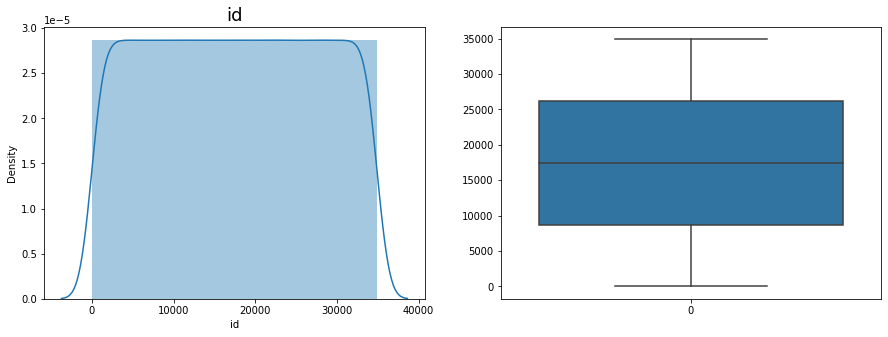

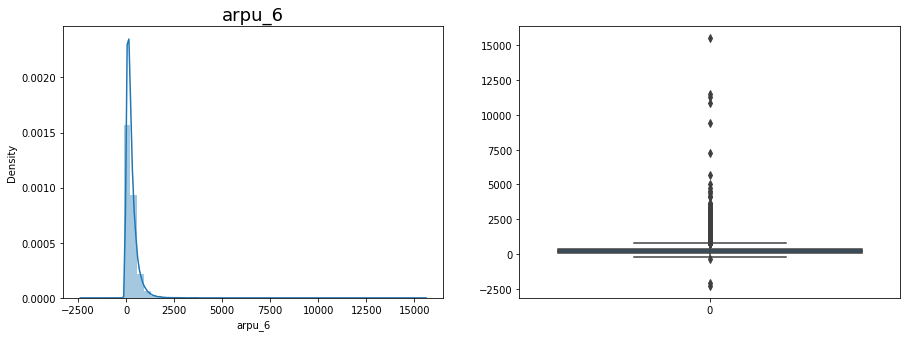

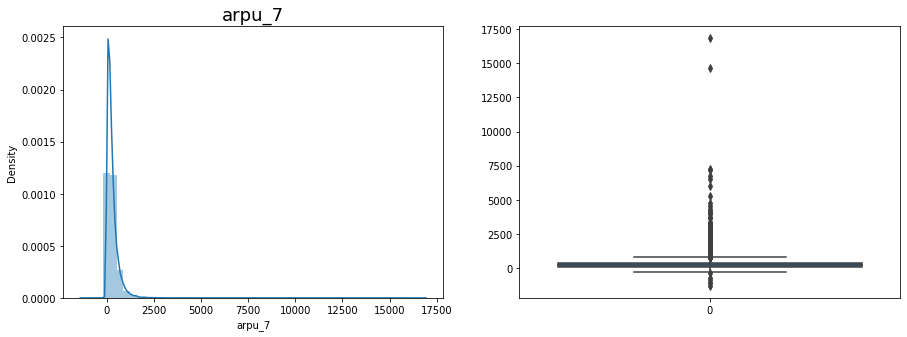

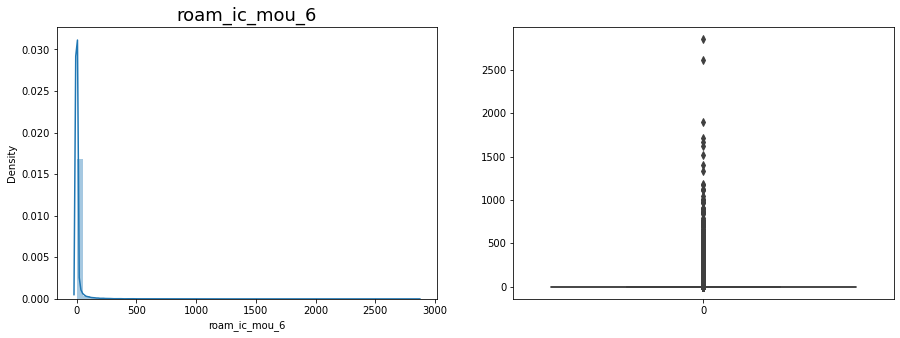

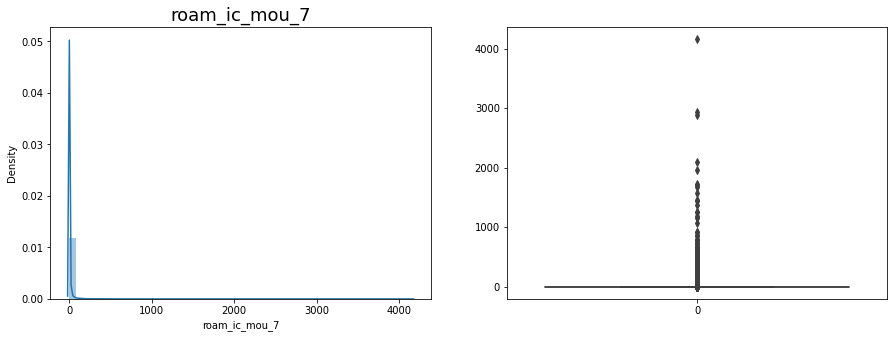

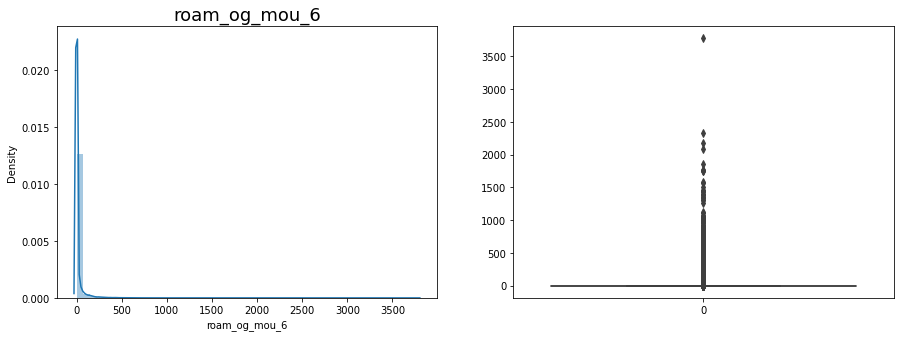

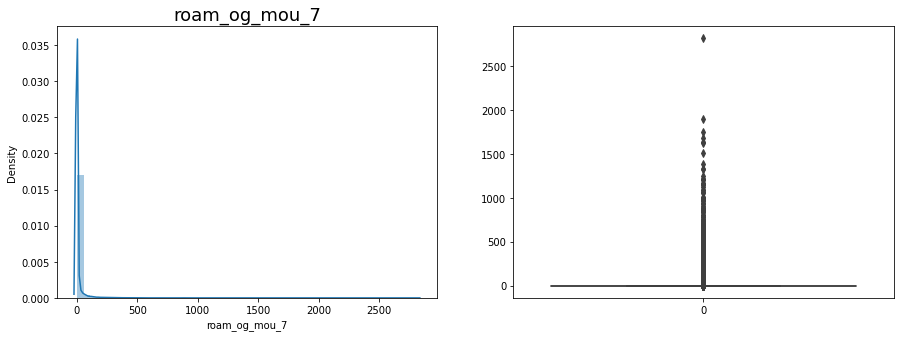

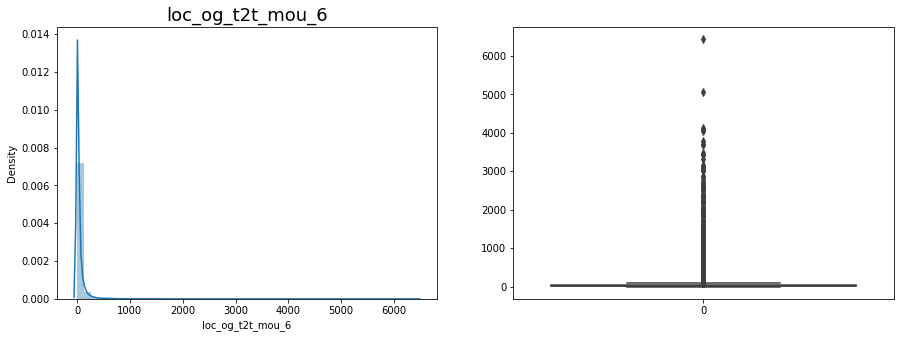

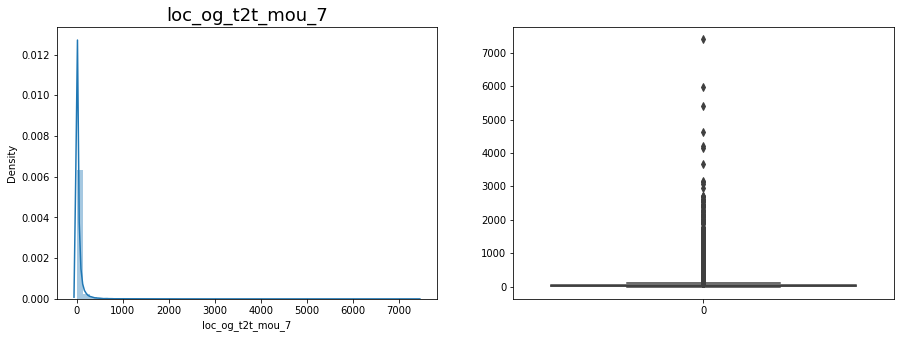

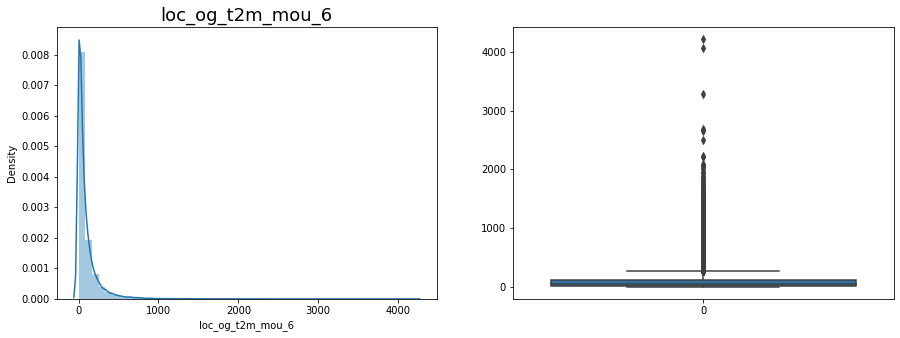

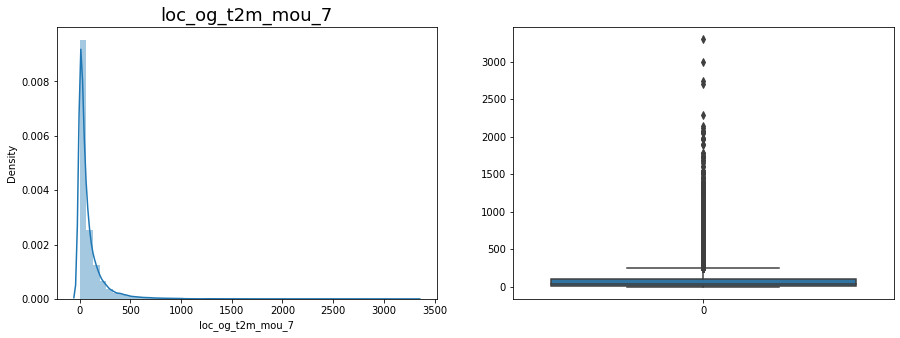

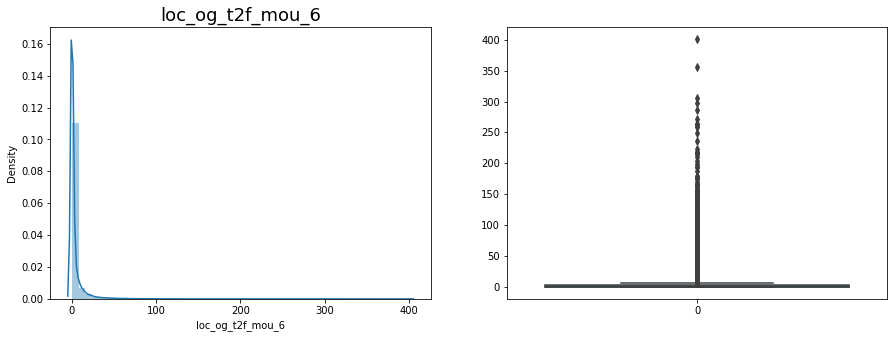

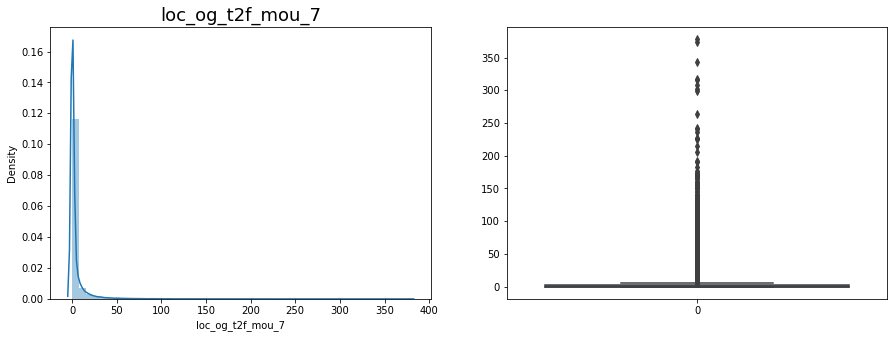

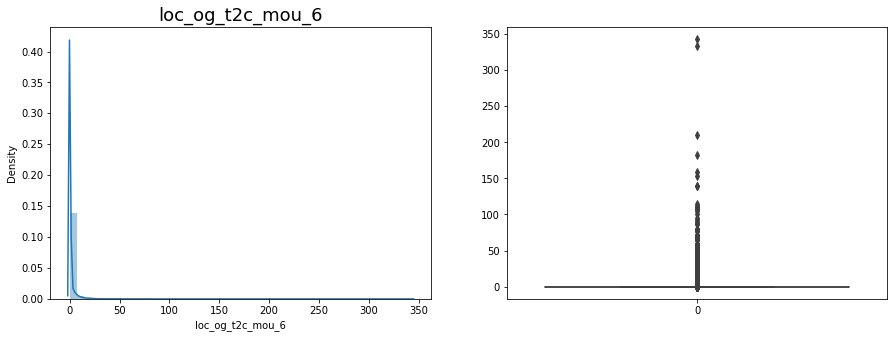

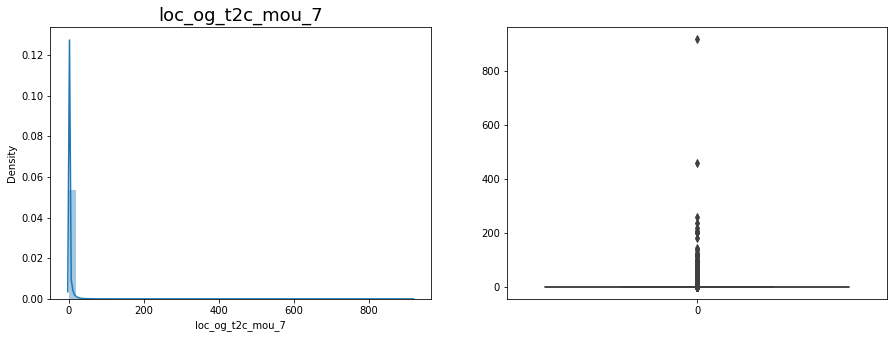

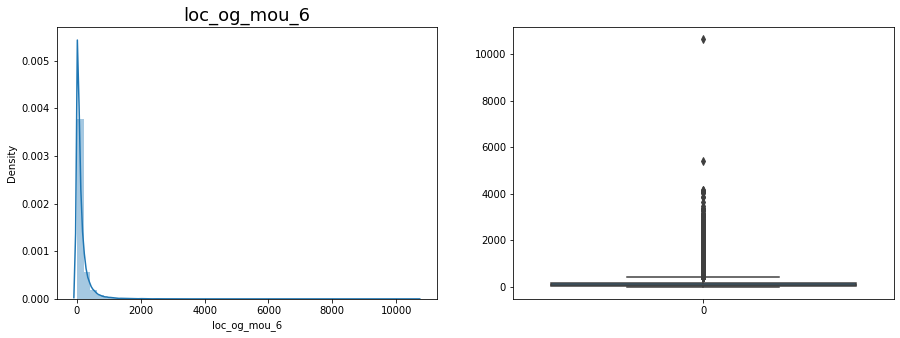

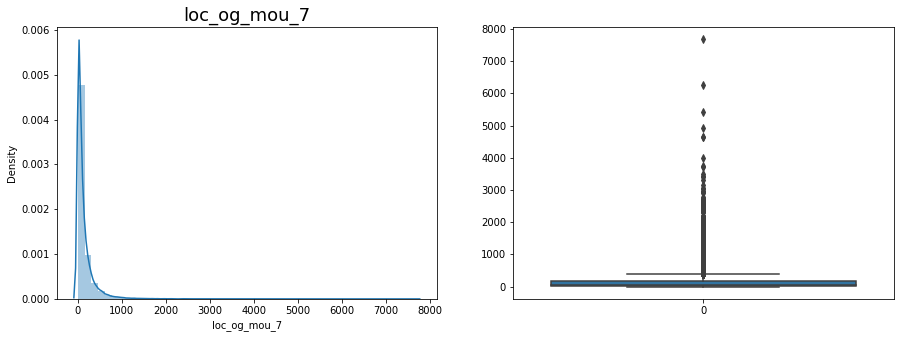

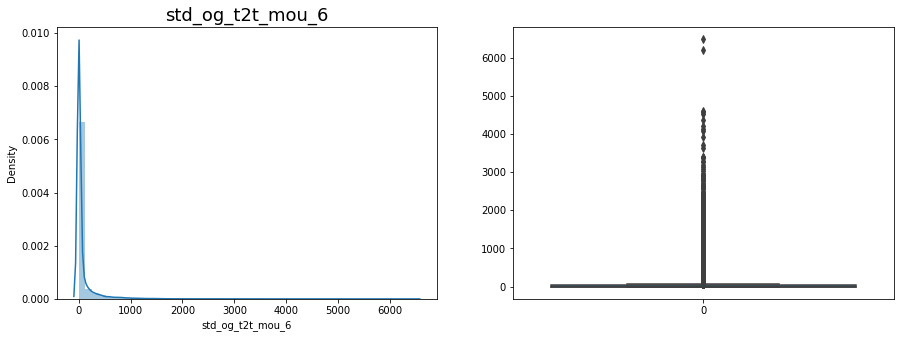

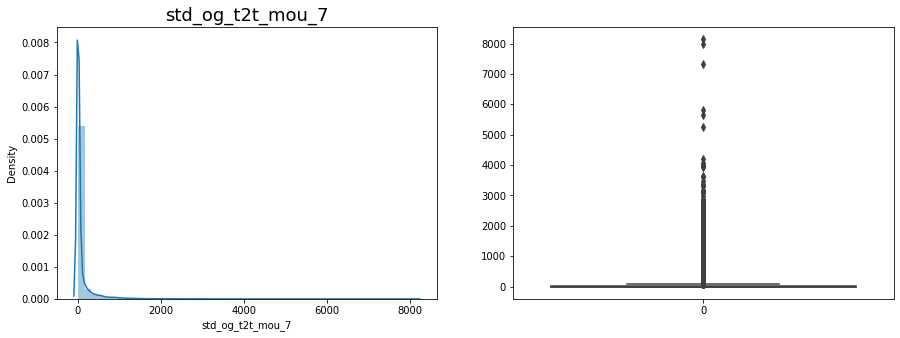

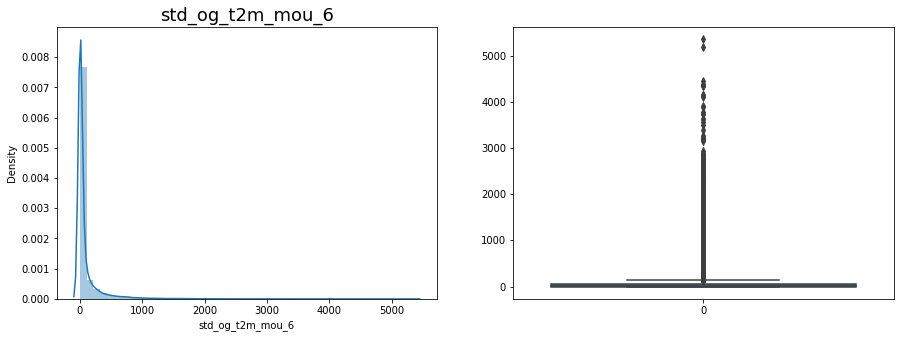

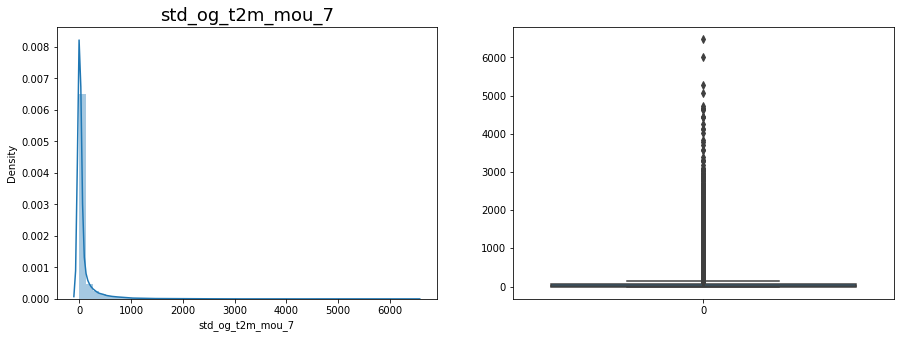

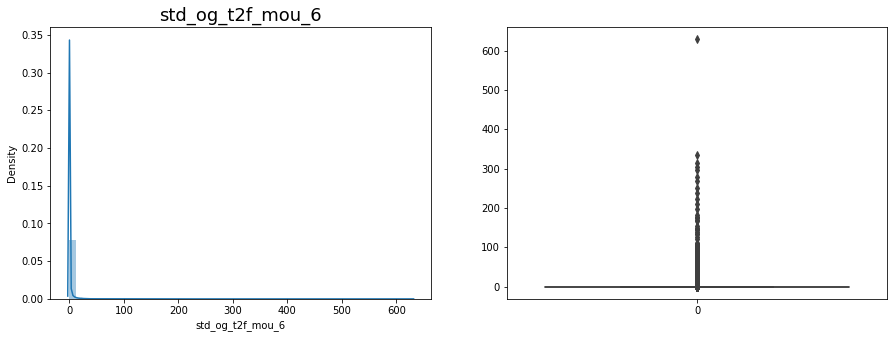

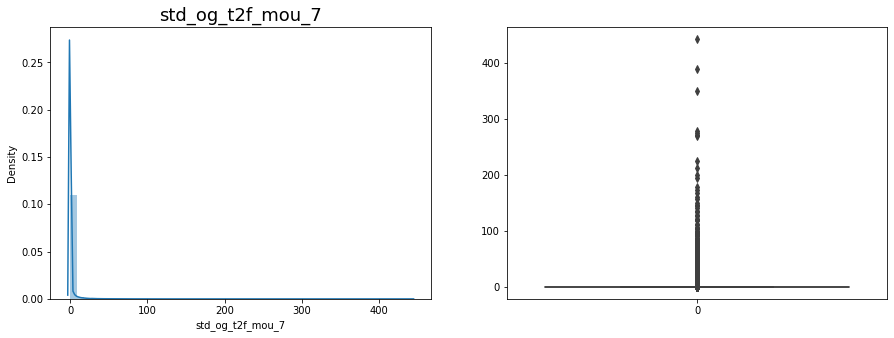

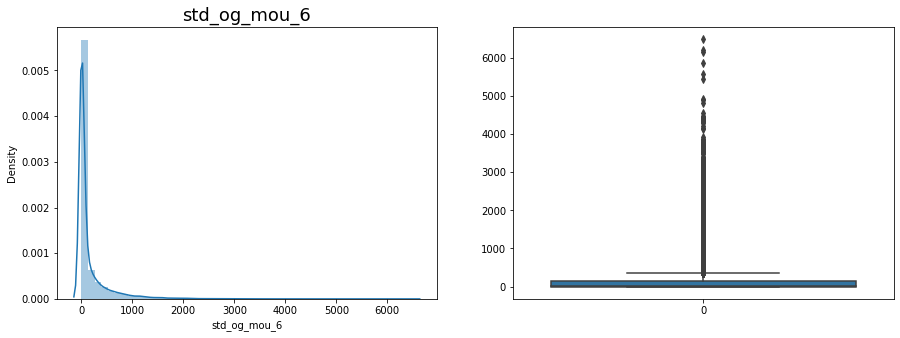

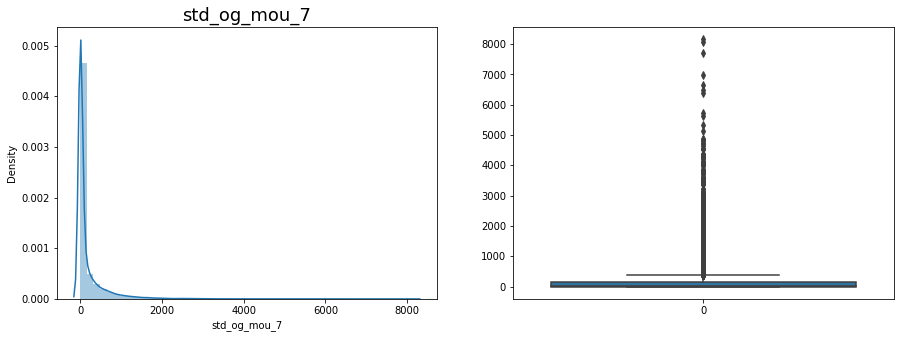

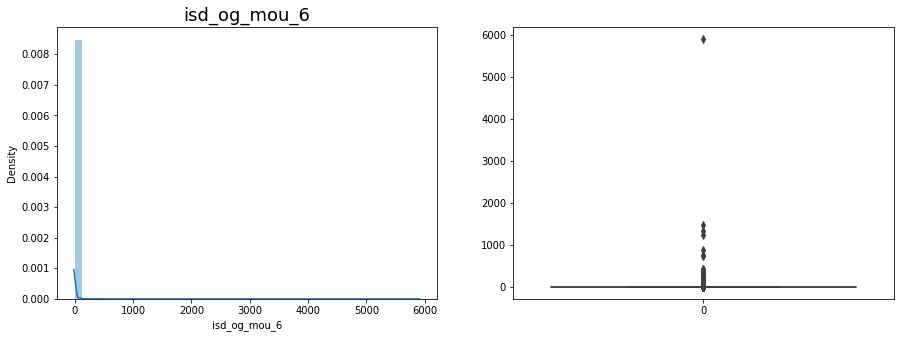

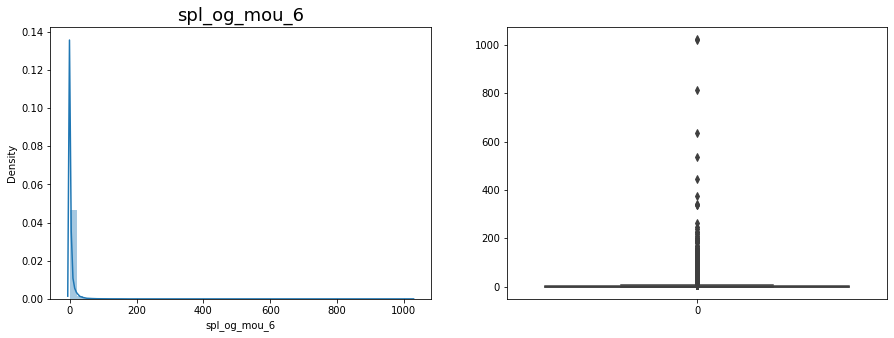

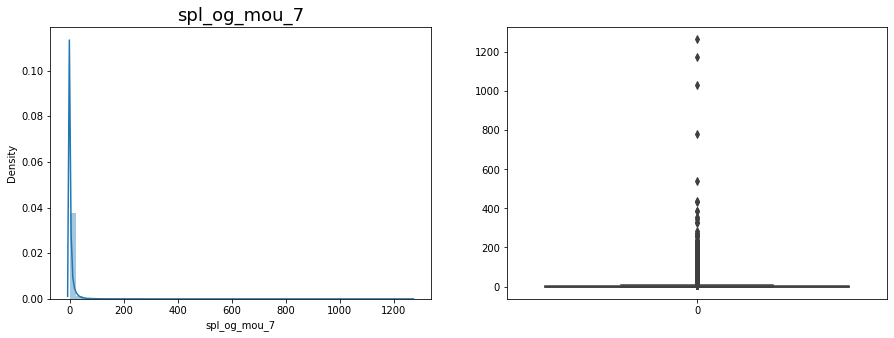

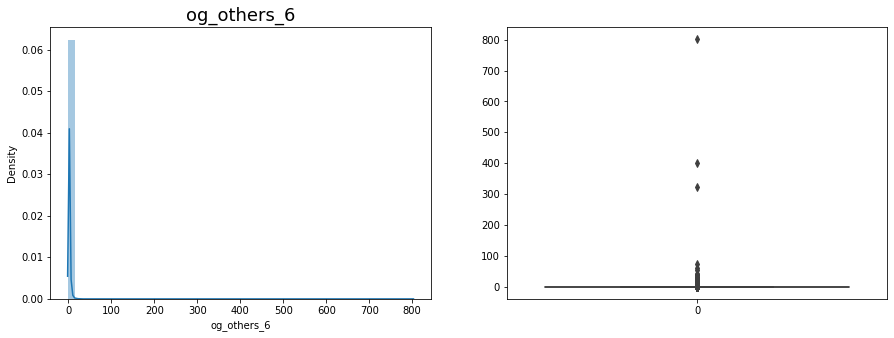

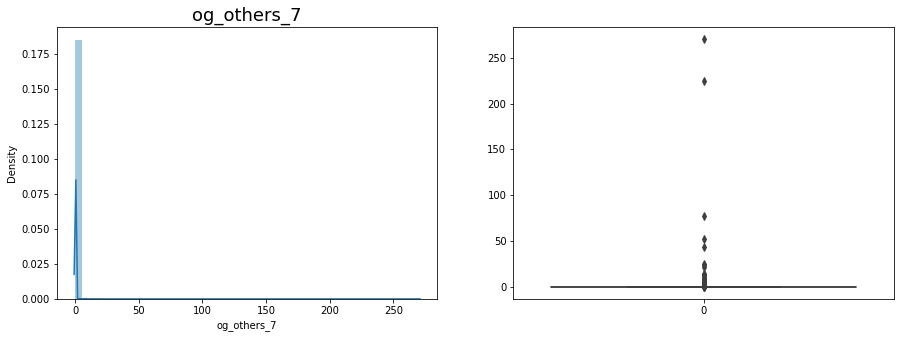

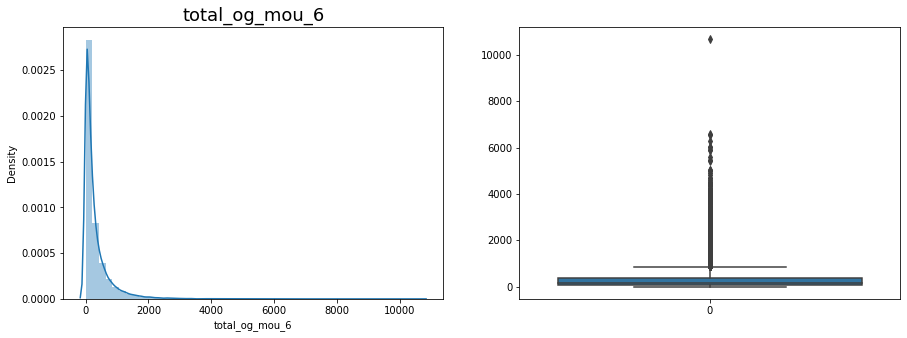

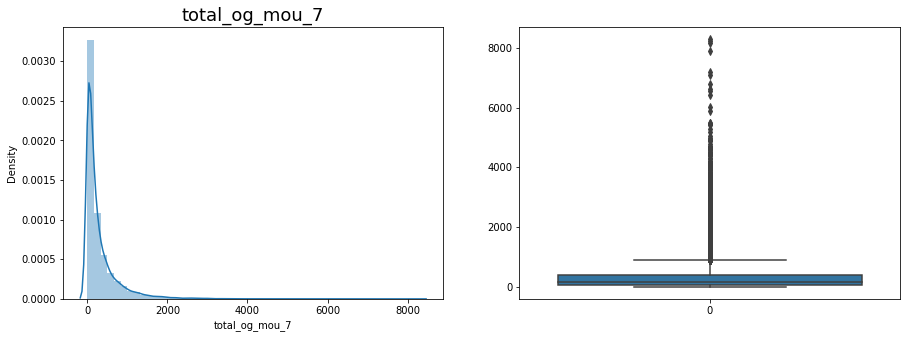

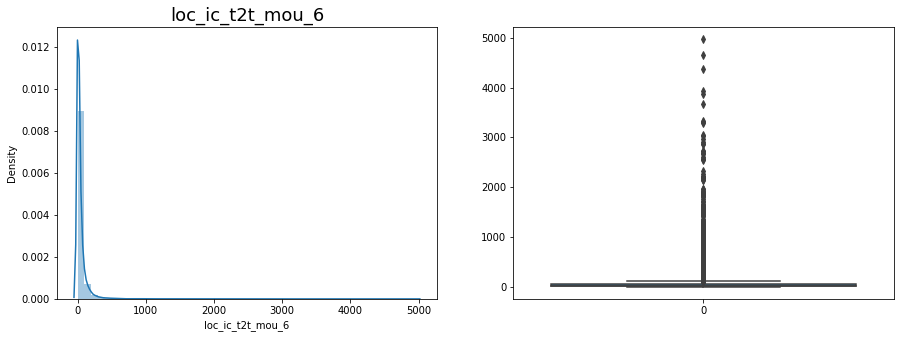

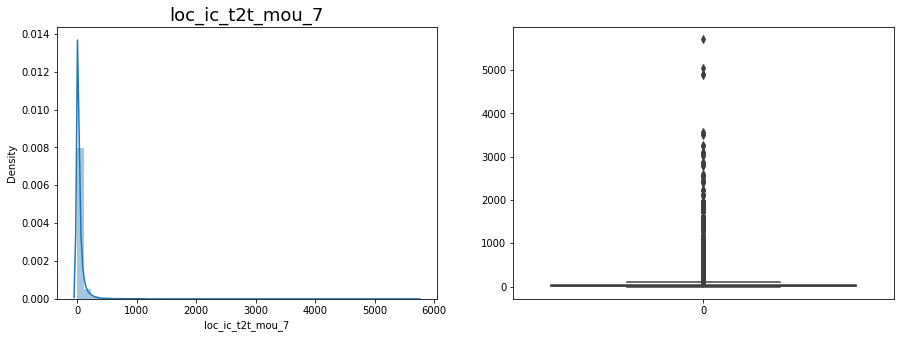

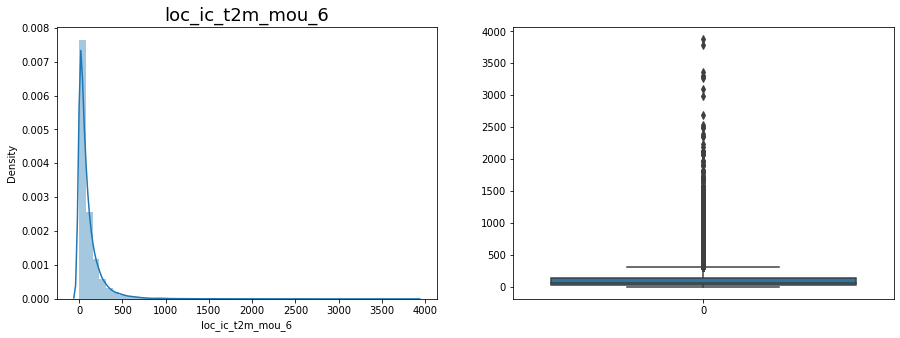

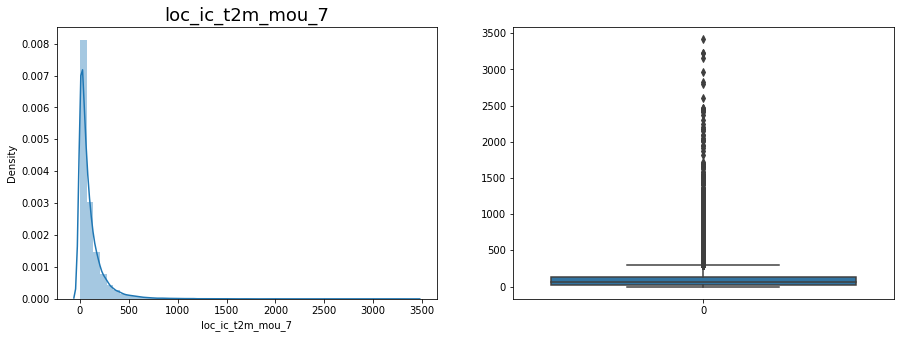

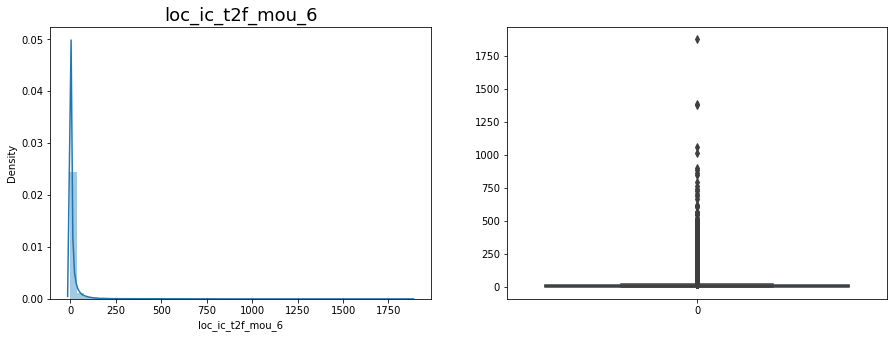

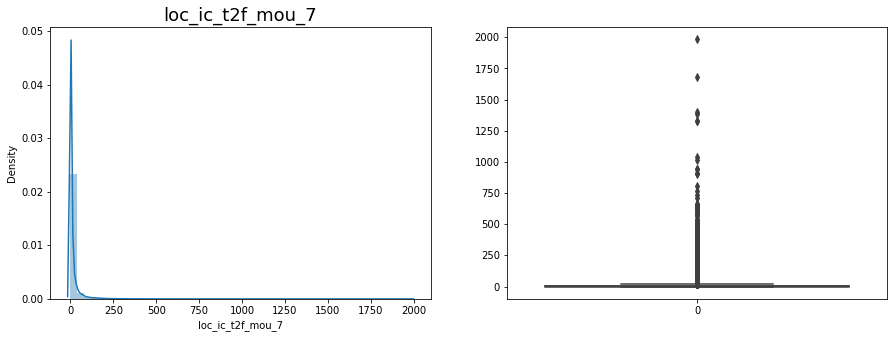

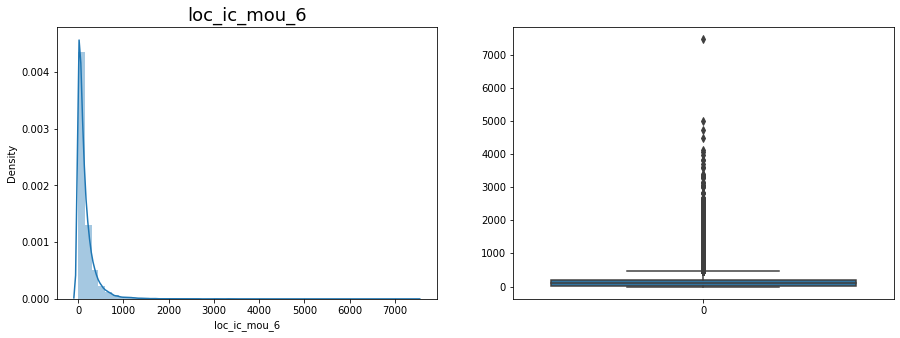

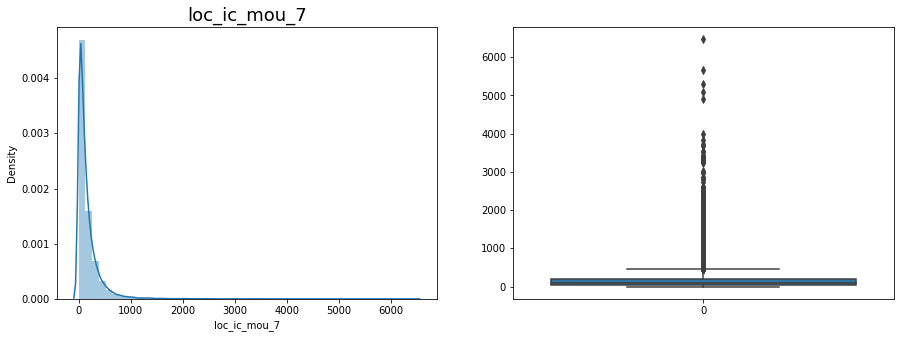

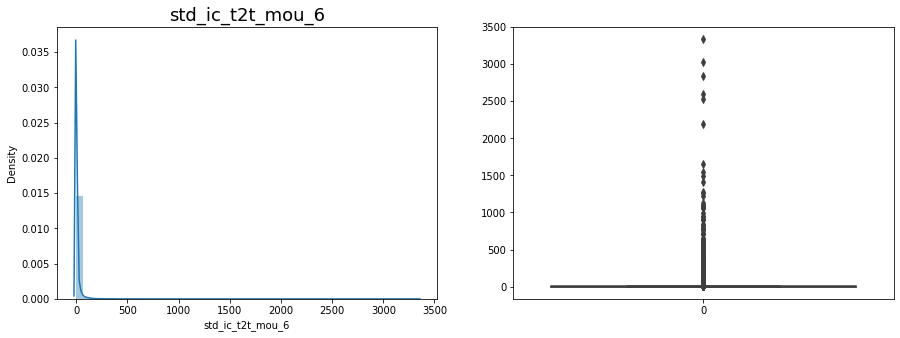

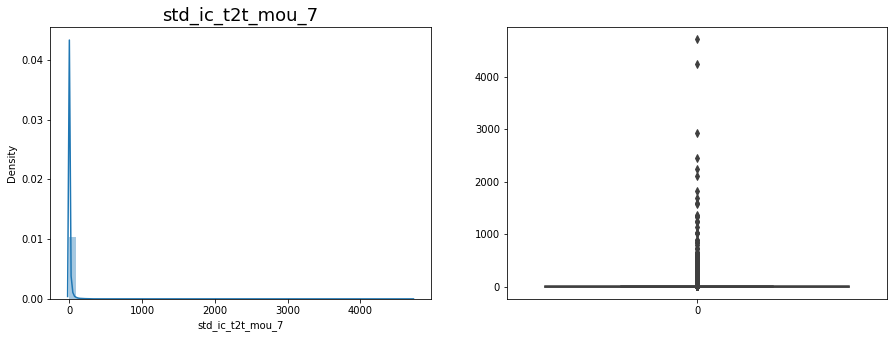

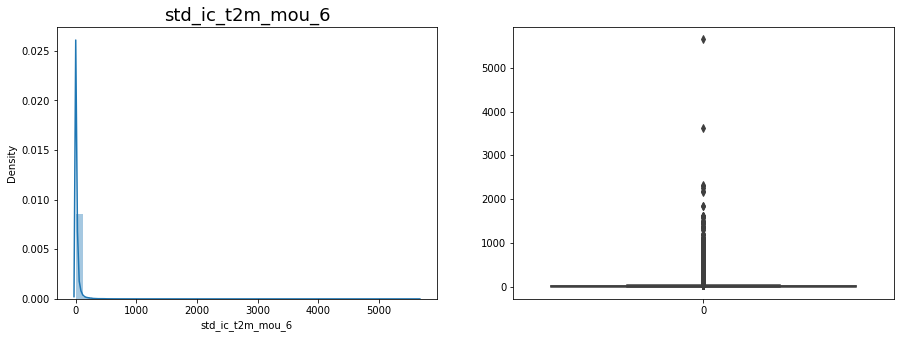

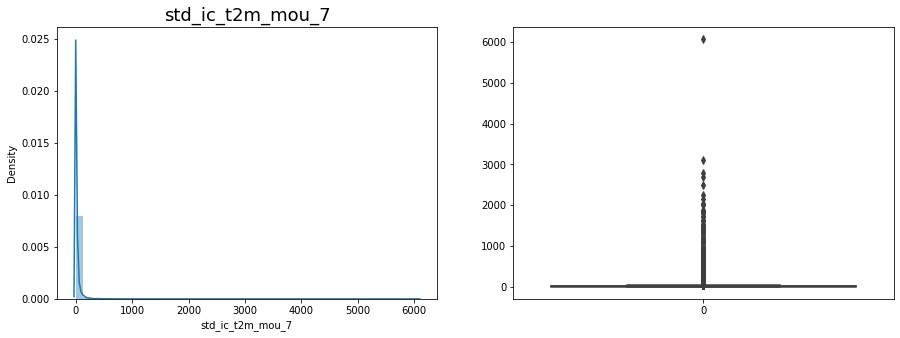

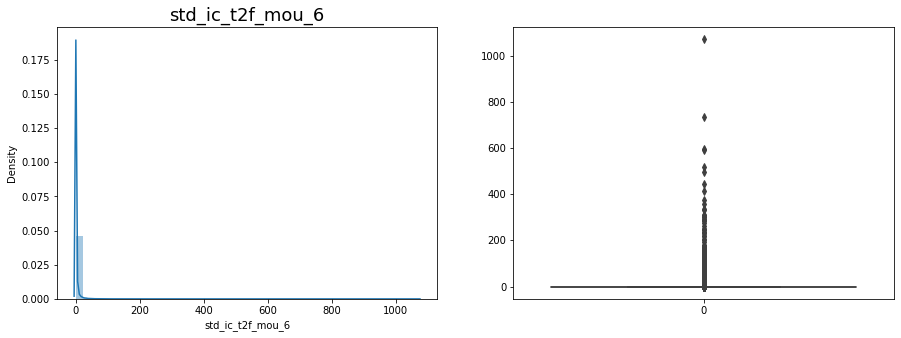

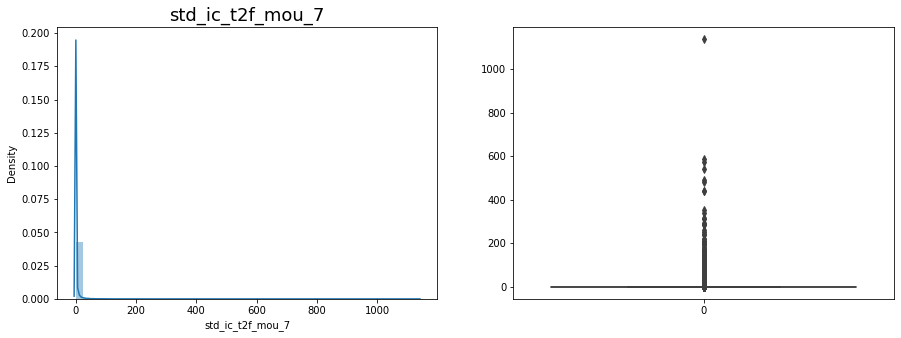

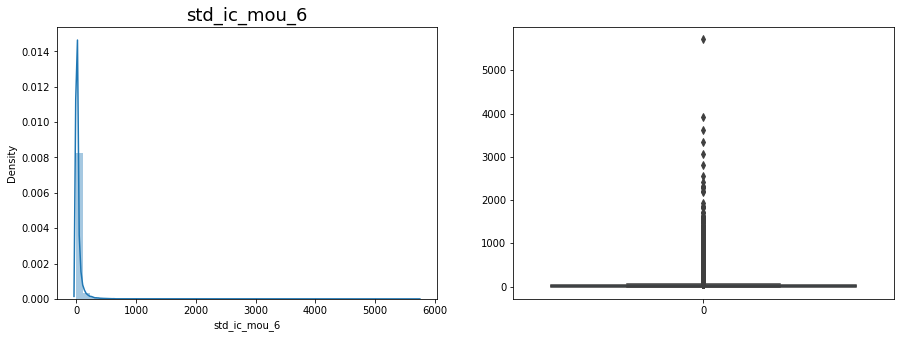

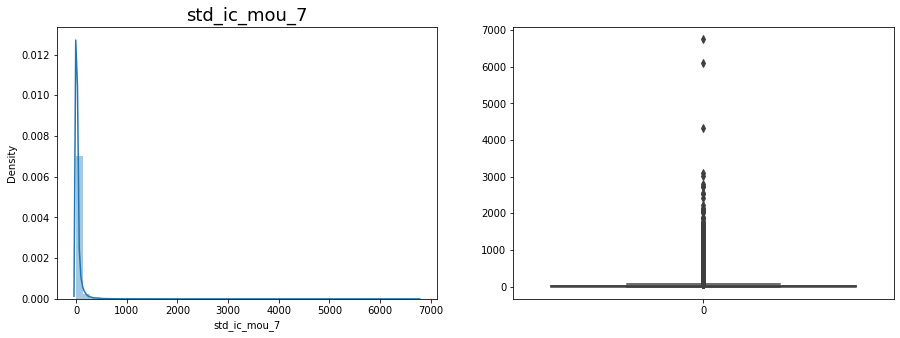

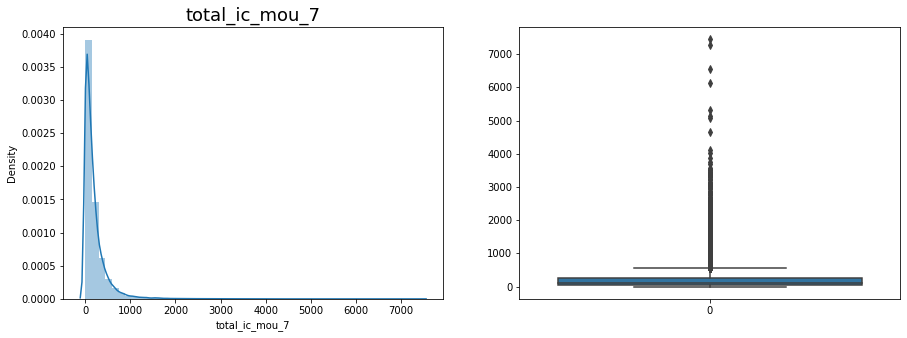

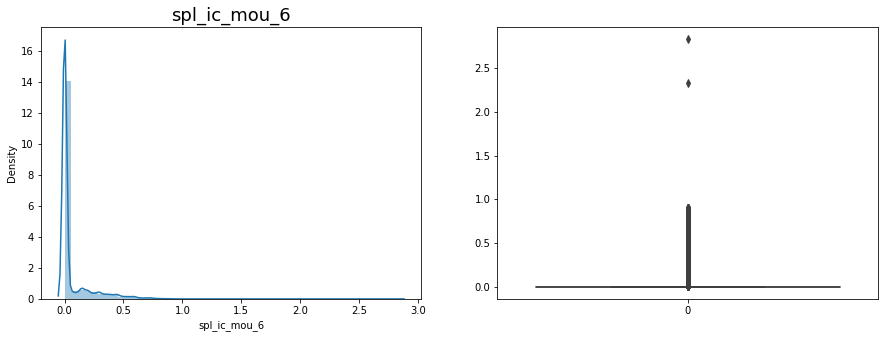

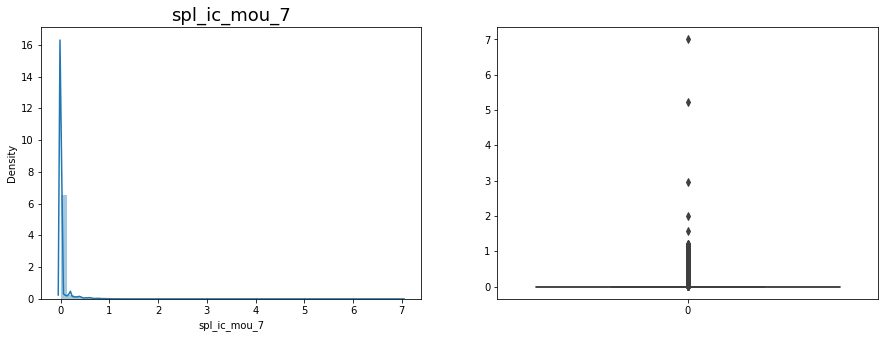

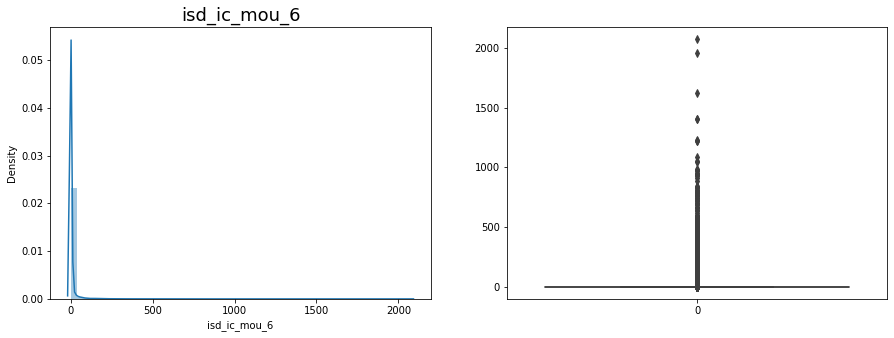

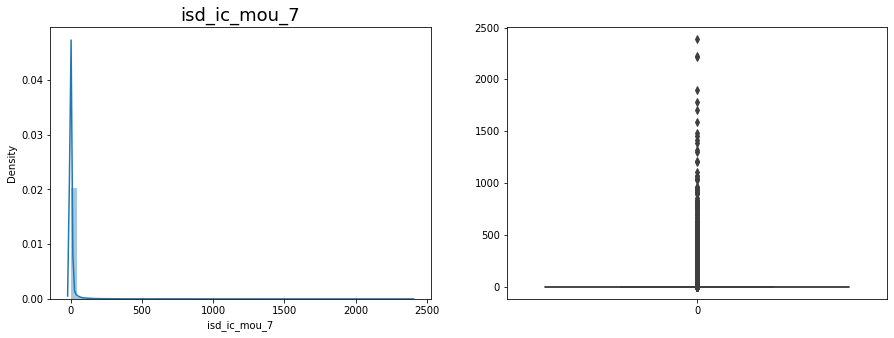

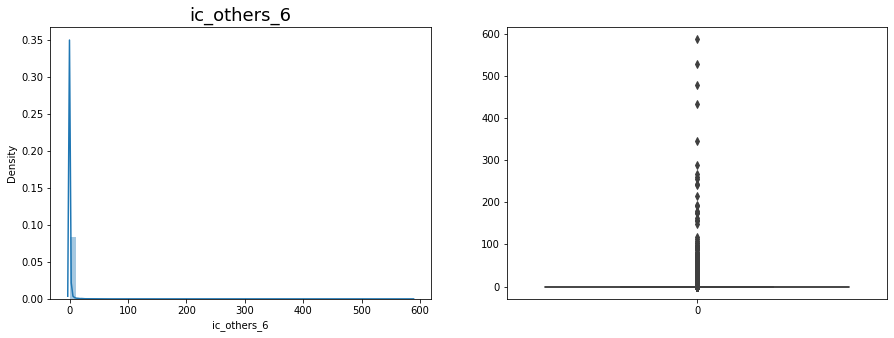

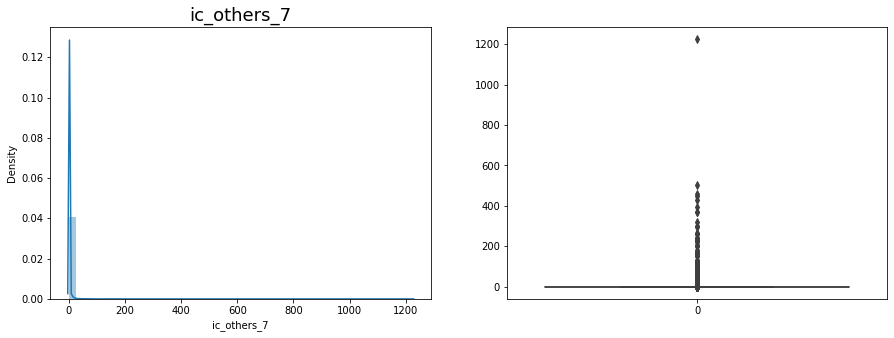

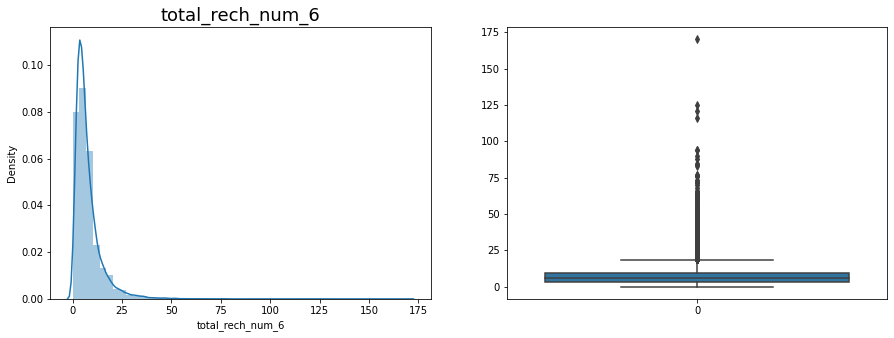

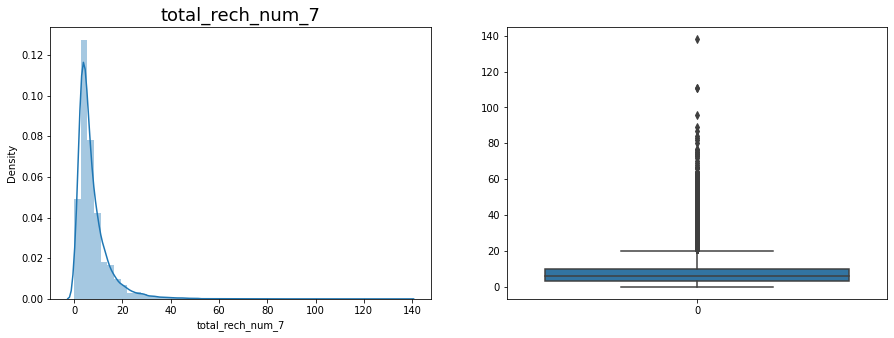

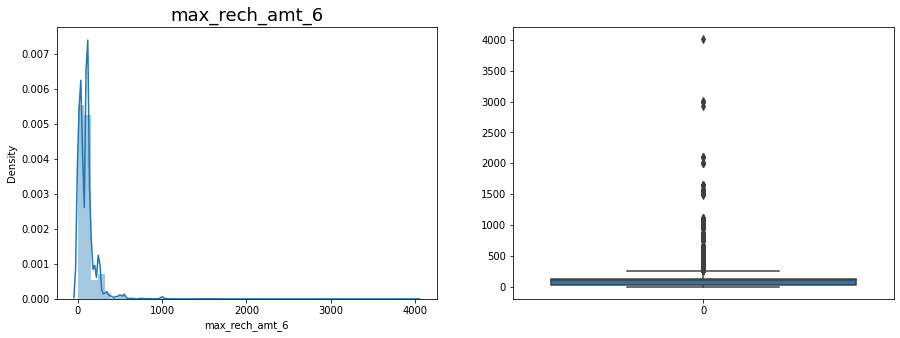

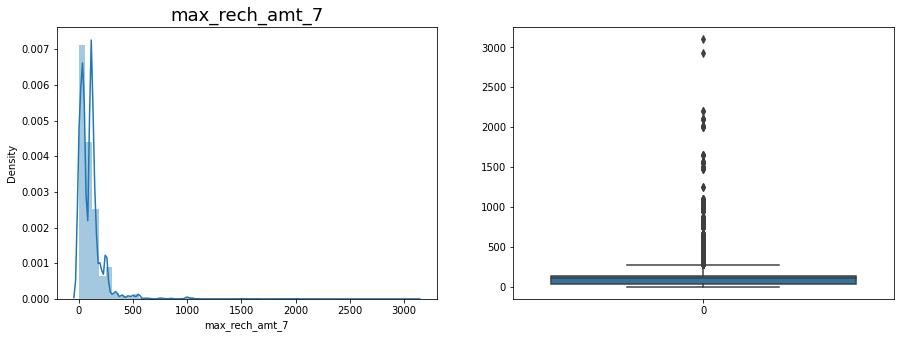

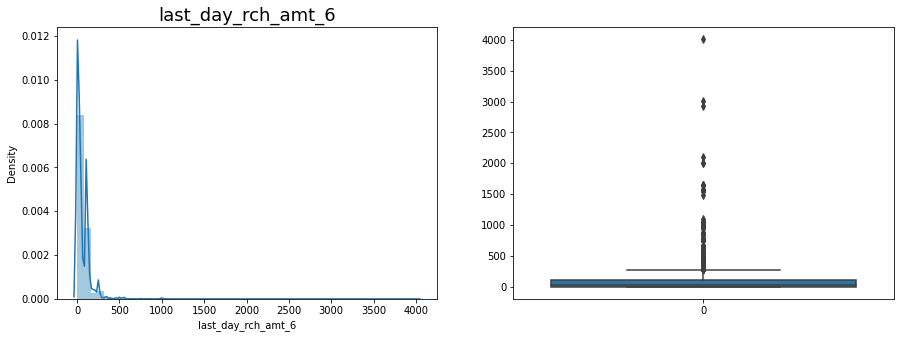

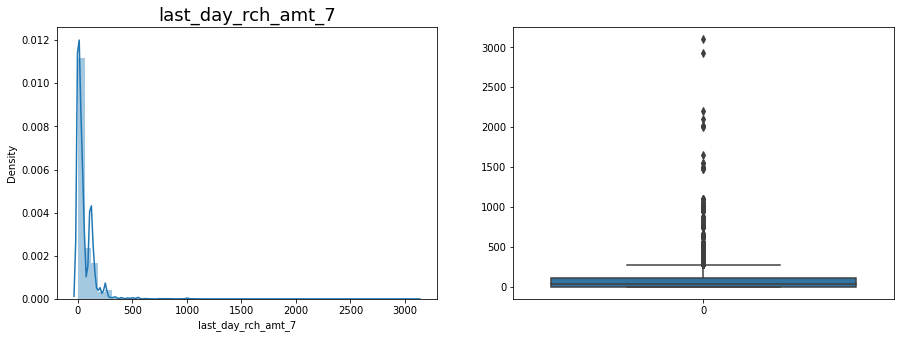

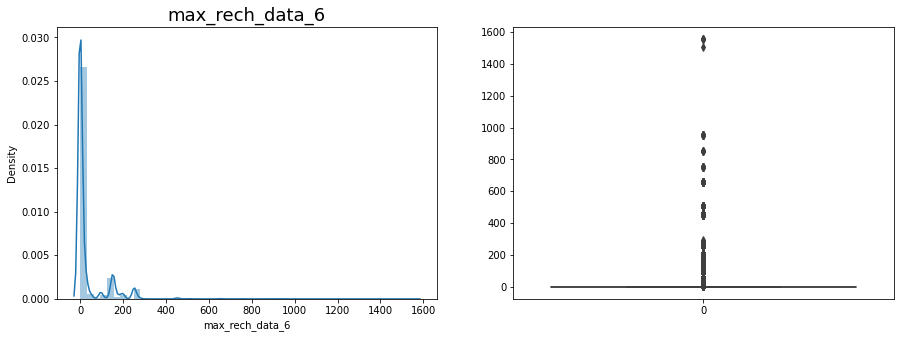

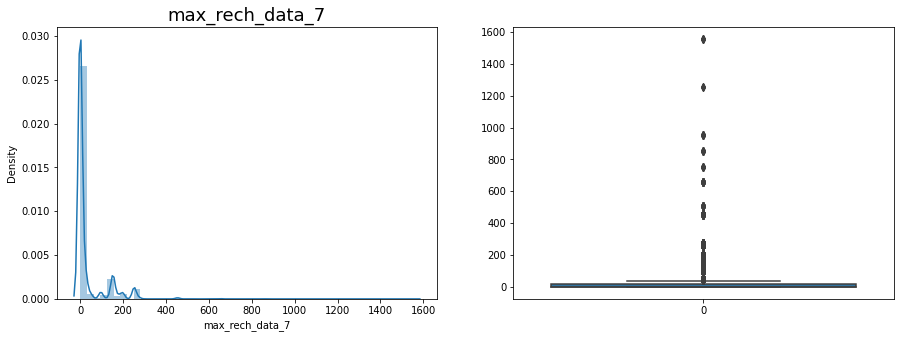

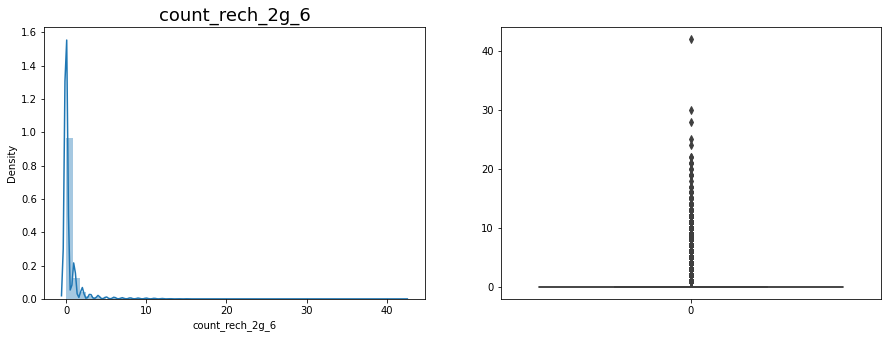

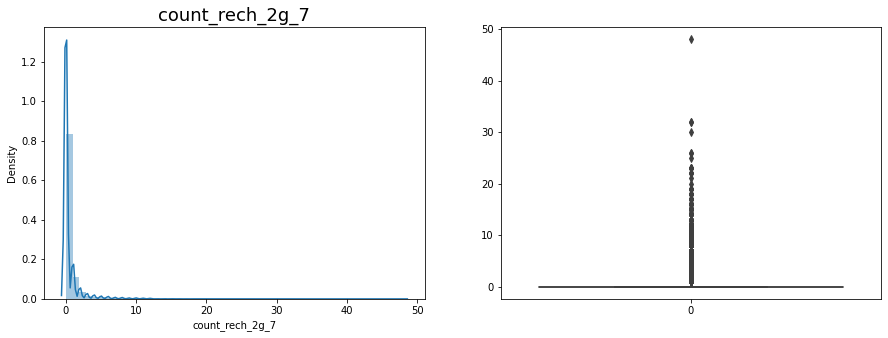

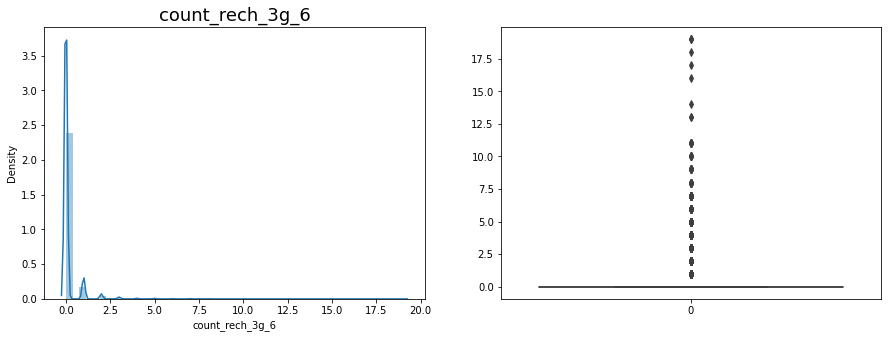

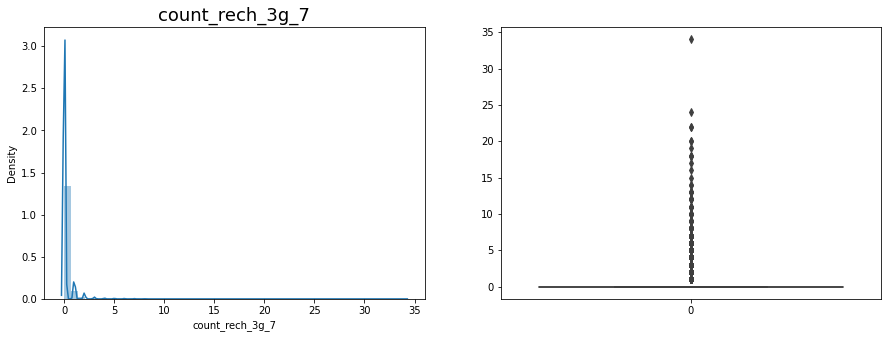

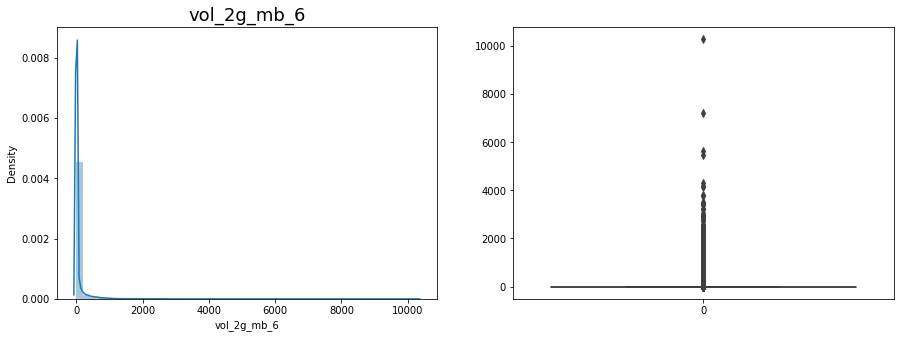

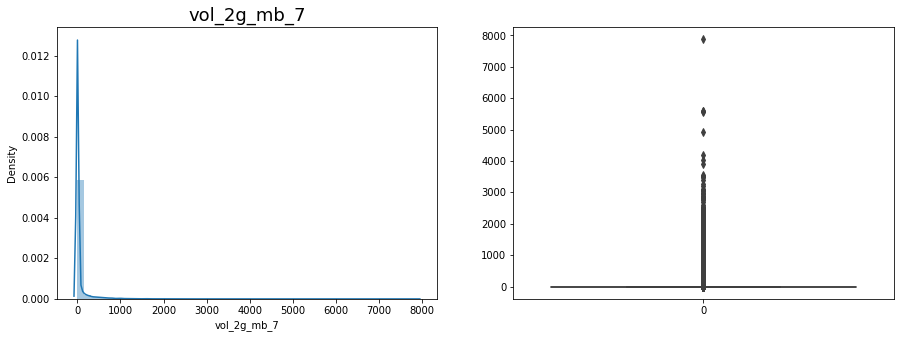

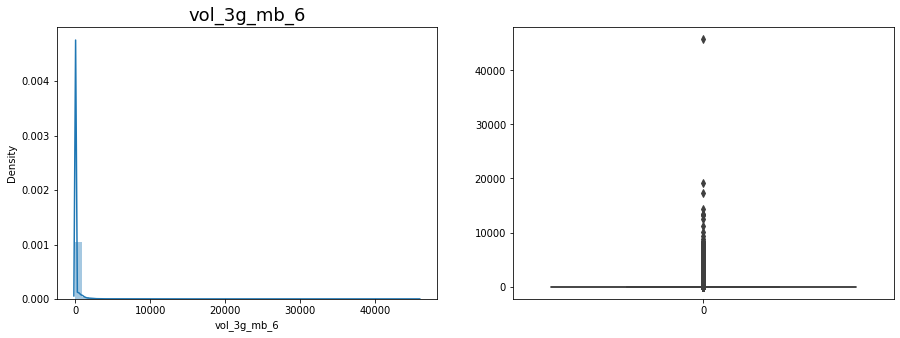

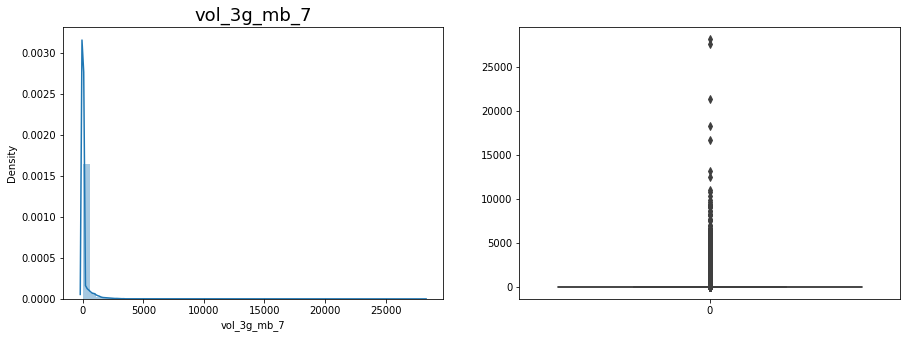

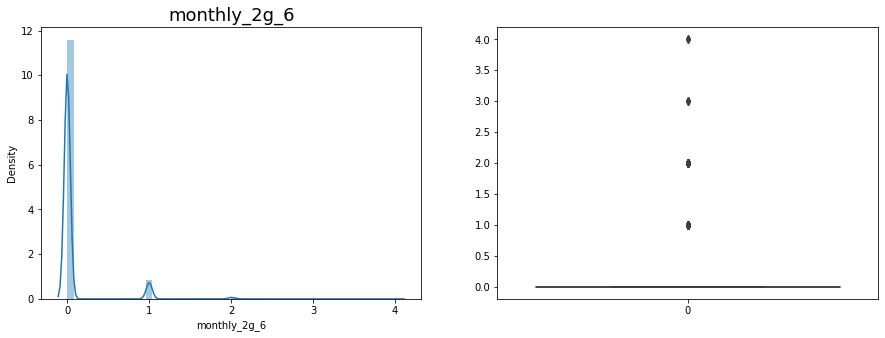

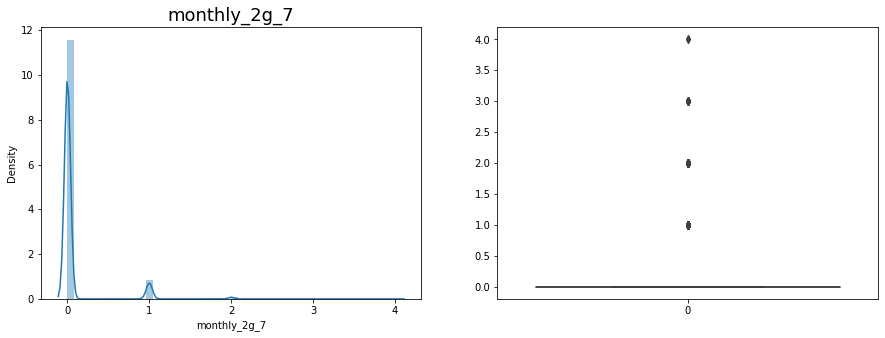

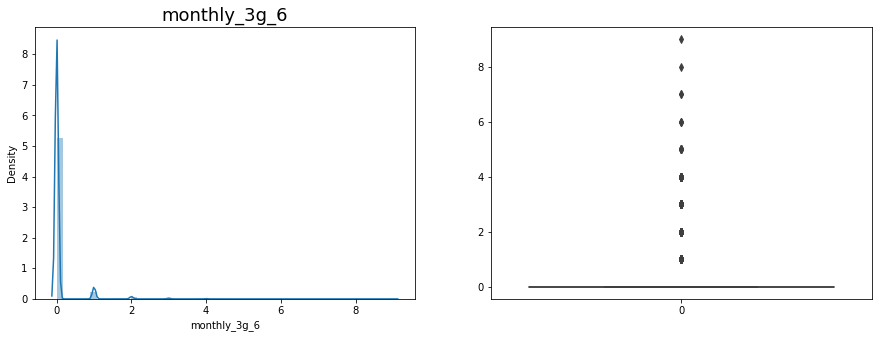

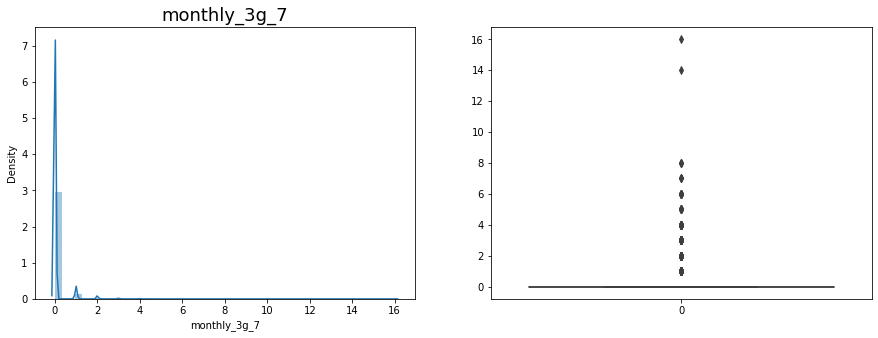

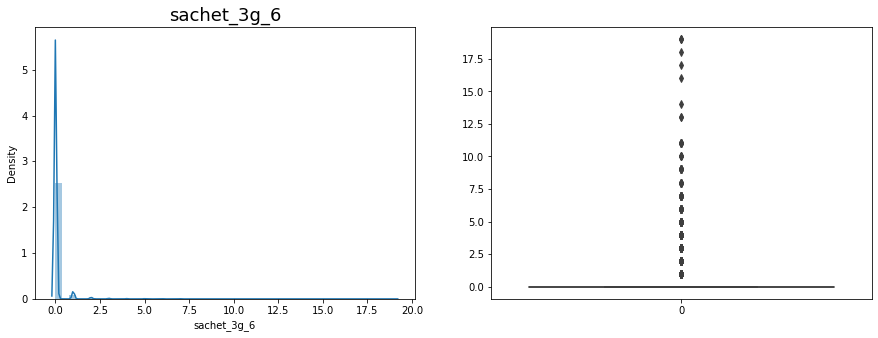

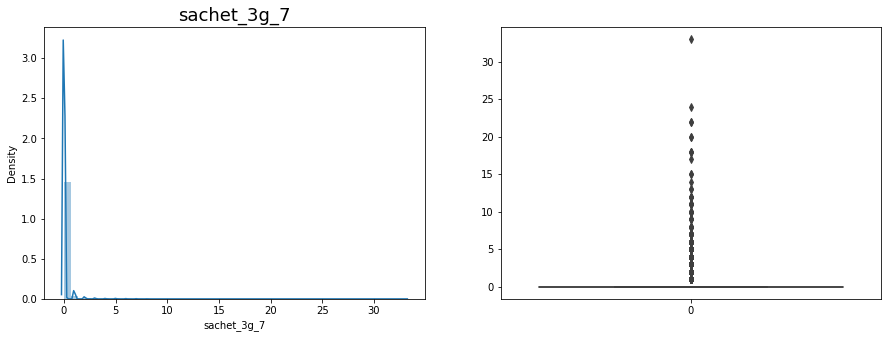

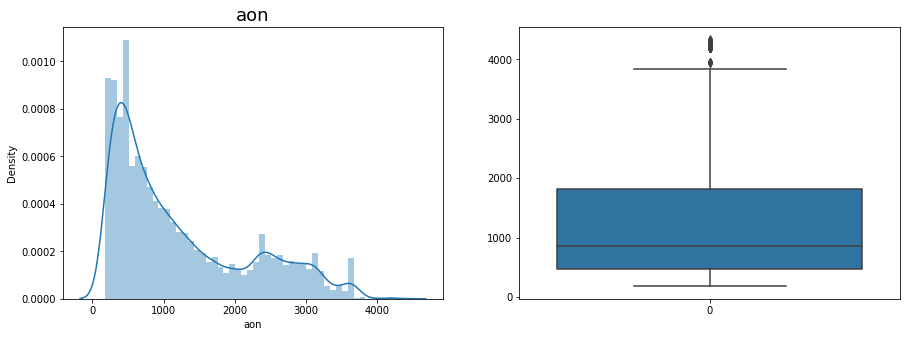

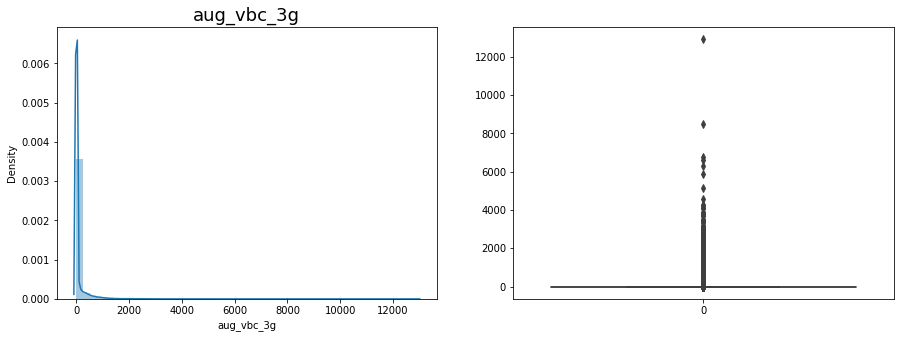

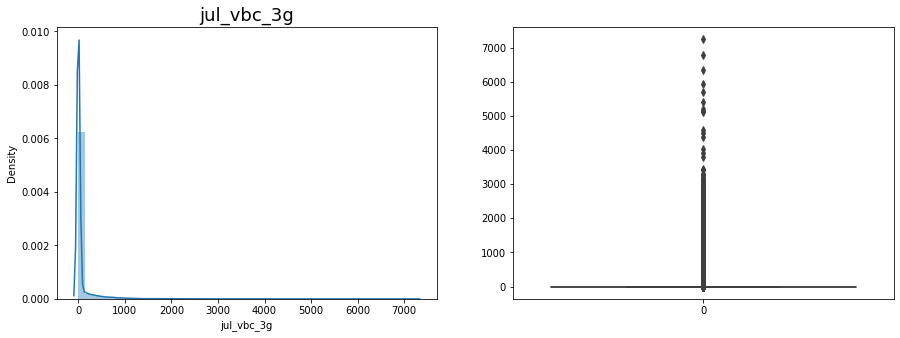

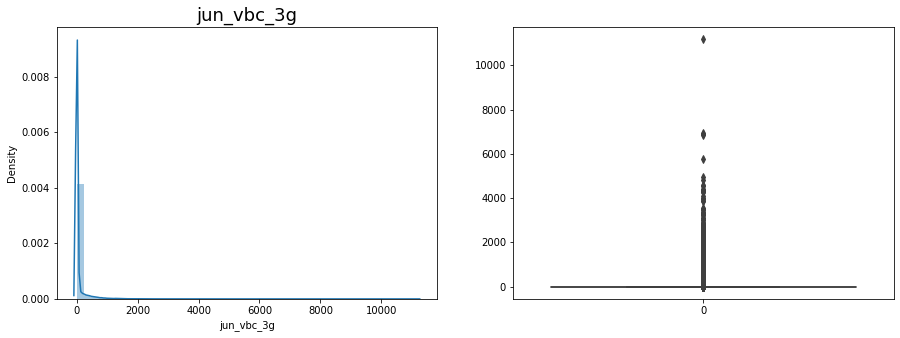

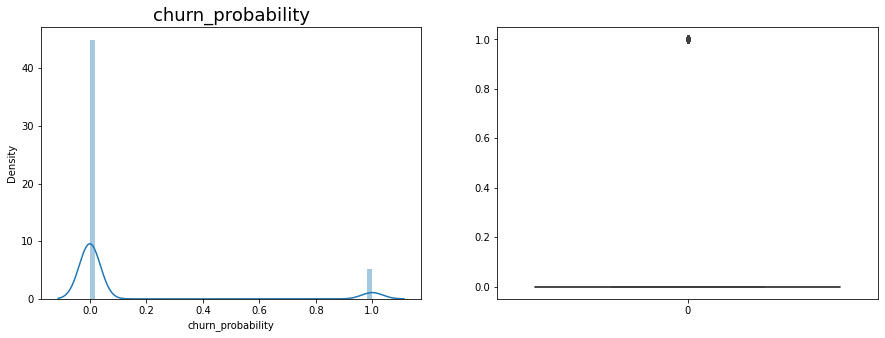

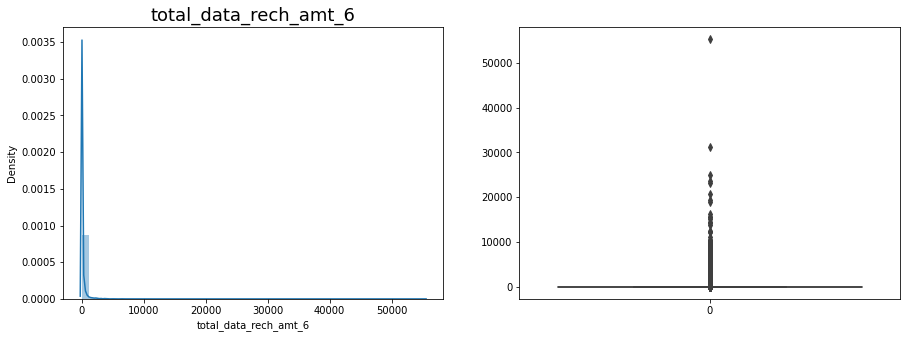

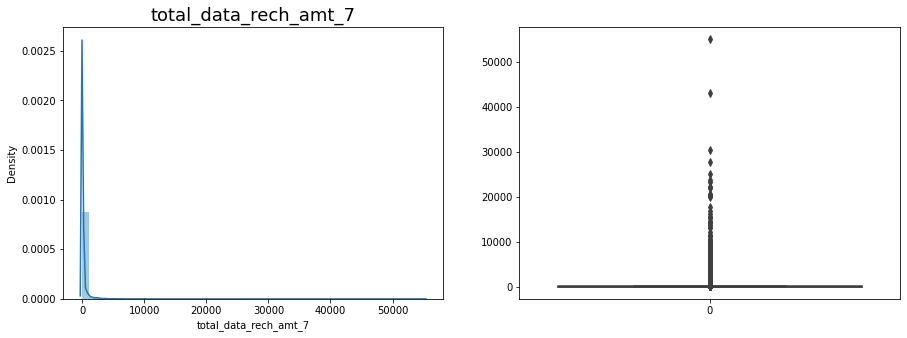

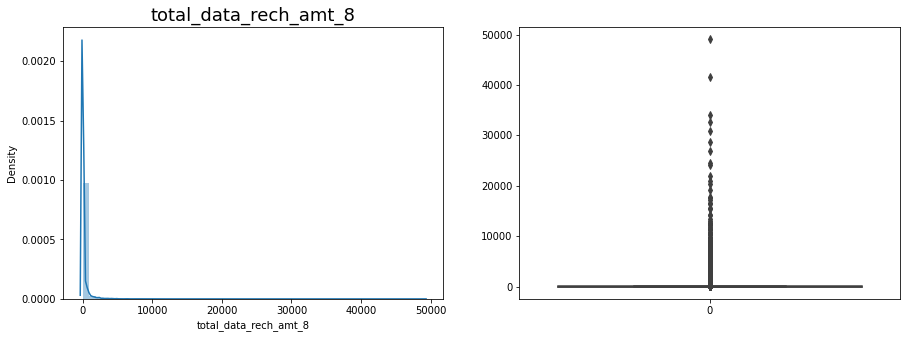

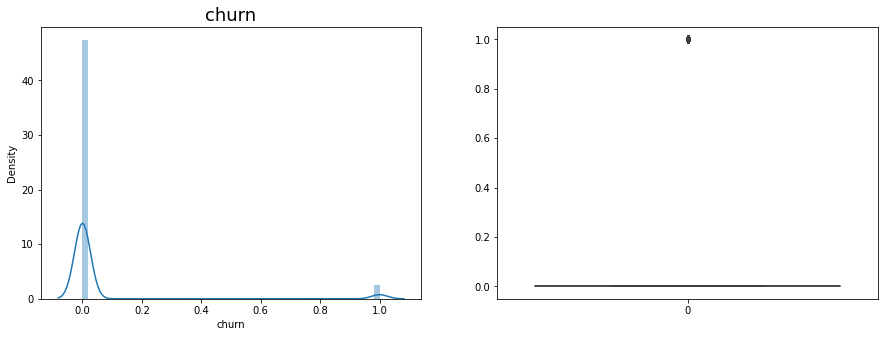

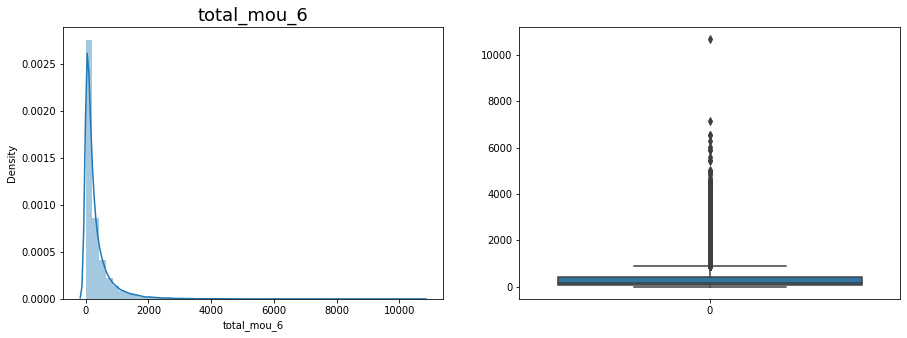

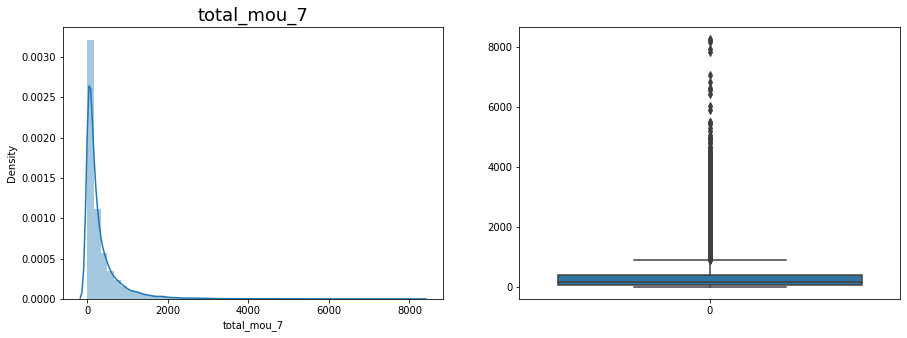

In [467]:
numerical_columns = telecom.select_dtypes(include=['number']).columns
print(numerical_columns)
for col in numerical_columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(telecom[col])
    plt.subplot(1,2,2)
    sns.boxplot(telecom[col])
    plt.show() 

# inference
# from the plots it is clear that most numerical columns have outlier
# need to perform some outlier treatment


Visualise categorical columns

In [468]:
cat_columns = telecom.select_dtypes(include=['object']).columns
cat_columns

# no categorical columns

Index([], dtype='object')

Plot Correlation matrix

In [469]:
# plt.figure(figsize = (50,50))
# sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
# plt.show()

Inference 
- You can see high cor-relation between certain variables.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

# Step 3: Data preparation and processing. 


Outlier Treatment

(34879, 88)
(34879, 88)


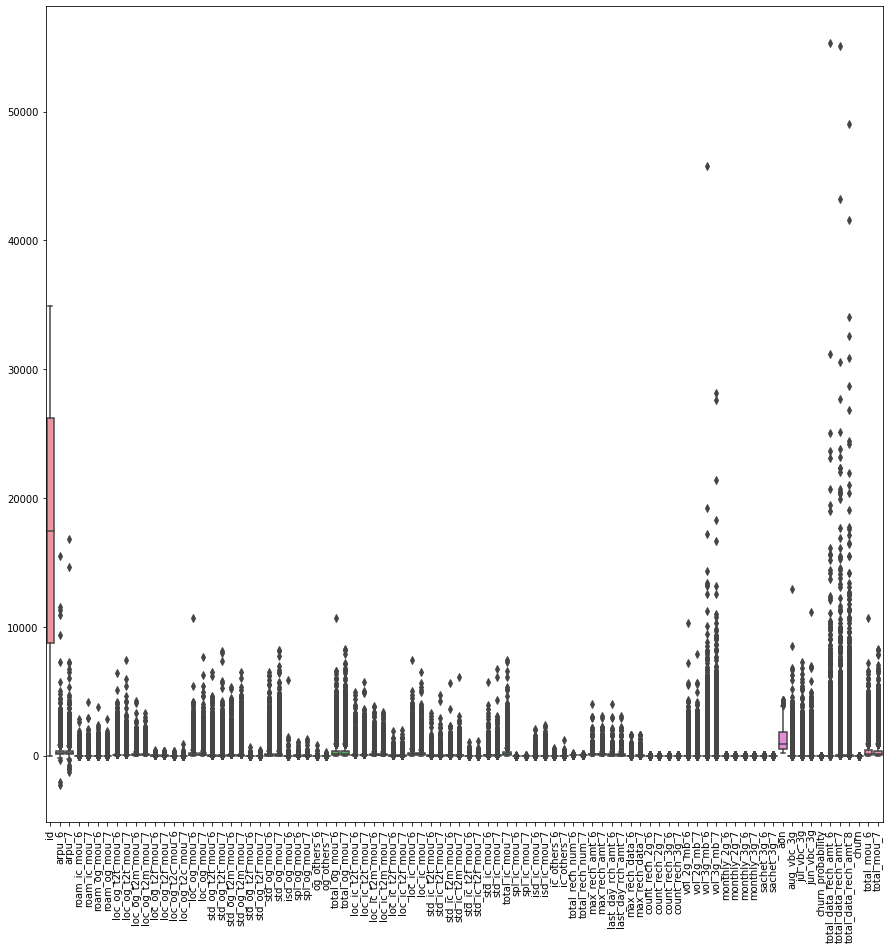

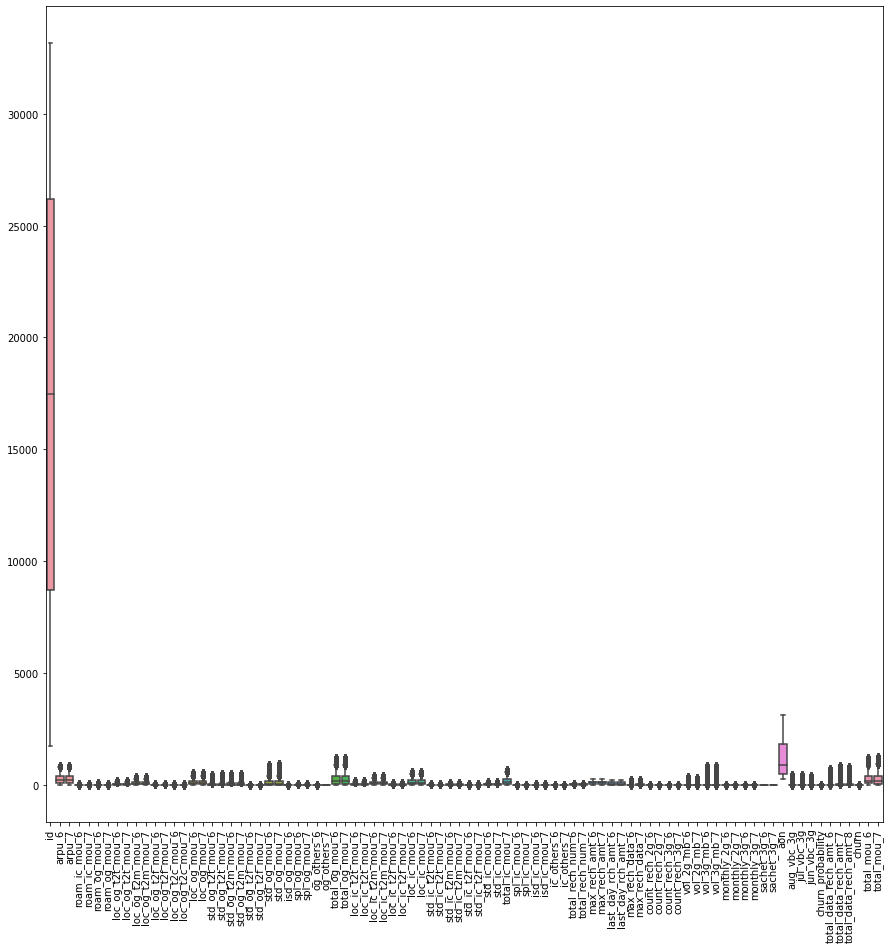

In [470]:
print(telecom.shape)
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);

# keeping values with lower bound a 5% and upper bound as 95%
telecom[numerical_columns] = telecom[numerical_columns].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
# check boxplots again to see if outliers are treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);
print(telecom.shape)

# Outliers have been treated.

#Step 4: Model Building

In [496]:
#round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print(telecom.shape)
telecom = telecom.dropna(axis=0)
print(telecom.shape)

# 2000 rows removed.

(34879, 88)
(32802, 88)


Empty DataFrame
Columns: [Number of Missing Values]
Index: []

In [497]:
X = telecom.drop(["id", "churn", "churn_probability"], axis=1).copy()
X.head()

arpu_6   arpu_7  roam_ic_mou_6  roam_ic_mou_7  roam_og_mou_6  \
0   31.277   87.009         0.0000            0.0           0.00   
1    1.000  122.787         0.0000            0.0           0.00   
2   60.806  103.176         0.0000            0.0           0.00   
3  156.362  205.260         0.0000            0.0           0.00   
4  240.708  128.191        42.7375            0.0          15.73   

   roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2m_mou_6  \
0            0.0              2.23              0.00              5.29   
1            0.0              0.00              0.00              0.00   
2            0.0              0.53             12.98             24.11   
3            0.0              6.99              3.94             37.91   
4            0.0             10.16              4.83             36.74   

   loc_og_t2m_mou_7  ...  sachet_3g_7     aon  aug_vbc_3g  jul_vbc_3g  \
0             16.04  ...          0.0  1958.0         0.0         0.0   
1              0.00  ...          0.0   710.0         0.0         0.0   
2              0.00  ...          0.0   882.0         0.0         0.0   
3             44.89  ...          0.0   982.0         0.0         0.0   
4             19.88  ...          0.0   647.0         0.0         0.0   

   jun_vbc_3g  total_data_rech_amt_6  total_data_rech_amt_7  \
0         0.0                    0.0                    0.0   
1         0.0                    0.0                  145.0   
2         0.0                    0.0                    0.0   
3         0.0                    0.0                    0.0   
4         0.0                  686.0                  820.5   

   total_data_rech_amt_8  total_mou_6  total_mou_7  
0                    0.0        80.82       221.06  
1                    0.0         0.00        25.99  
2                    0.0        54.52        97.98  
3                    0.0        76.02        94.49  
4                  808.0        78.27        42.94  

[5 rows x 85 columns]

In [498]:
y = telecom["churn"].copy()
y.head()


0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [499]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

(26241, 85)
(26241,)


Scaling

In [500]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [501]:
## Create a scaling instance
scaler = StandardScaler()
## Scale the numerical columns 
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train.describe()

arpu_6        arpu_7  roam_ic_mou_6  roam_ic_mou_7  \
count  2.624100e+04  2.624100e+04   2.624100e+04   2.624100e+04   
mean  -9.192838e-17 -5.686291e-17   9.866393e-17  -6.227843e-18   
std    1.000019e+00  1.000019e+00   1.000019e+00   1.000019e+00   
min   -1.212280e+00 -1.185506e+00  -3.537976e-01  -3.293455e-01   
25%   -7.584635e-01 -7.625311e-01  -3.537976e-01  -3.293455e-01   
50%   -2.896802e-01 -2.986028e-01  -3.537976e-01  -3.293455e-01   
75%    4.894845e-01  4.772817e-01  -3.537976e-01  -3.293455e-01   
max    2.488687e+00  2.488628e+00   3.691851e+00   3.768263e+00   

       roam_og_mou_6  roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   2.624100e+04   2.624100e+04      2.624100e+04      2.624100e+04   
mean    6.451233e-17  -1.232030e-17     -1.248276e-16      5.686291e-17   
std     1.000019e+00   1.000019e+00      1.000019e+00      1.000019e+00   
min    -3.616196e-01  -3.296058e-01     -6.990096e-01     -6.955595e-01   
25%    -3.616196e-01  -3.296058e-01     -6.598380e-01     -6.573493e-01   
50%    -3.616196e-01  -3.296058e-01     -4.405623e-01     -4.385092e-01   
75%    -3.616196e-01  -3.296058e-01      1.846931e-01      1.778468e-01   
max     3.628570e+00   3.743481e+00      2.991114e+00      3.005334e+00   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  ...  sachet_3g_7           aon  \
count      2.624100e+04      2.624100e+04  ...      26241.0  2.624100e+04   
mean      -1.314616e-16      7.649416e-18  ...          0.0 -3.357620e-17   
std        1.000019e+00      1.000019e+00  ...          0.0  1.000019e+00   
min       -8.274718e-01     -8.261750e-01  ...          0.0 -1.091575e+00   
25%       -7.233269e-01     -7.182024e-01  ...          0.0 -8.225392e-01   
50%       -3.976950e-01     -4.049355e-01  ...          0.0 -3.571508e-01   
75%        3.201684e-01      3.097305e-01  ...          0.0  7.211618e-01   
max        2.799646e+00      2.795555e+00  ...          0.0  2.029456e+00   

         aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  total_data_rech_amt_6  \
count  2.624100e+04  2.624100e+04  2.624100e+04           2.624100e+04   
mean  -7.744187e-17  3.845016e-17  6.606929e-17          -2.247439e-17   
std    1.000019e+00  1.000019e+00  1.000019e+00           1.000019e+00   
min   -3.562838e-01 -3.485462e-01 -3.392979e-01          -4.272275e-01   
25%   -3.562838e-01 -3.485462e-01 -3.392979e-01          -4.272275e-01   
50%   -3.562838e-01 -3.485462e-01 -3.392979e-01          -4.272275e-01   
75%   -3.562838e-01 -3.485462e-01 -3.392979e-01          -3.498628e-01   
max    3.514519e+00  3.572984e+00  3.630948e+00           3.363646e+00   

       total_data_rech_amt_7  total_data_rech_amt_8   total_mou_6  \
count           2.624100e+04           2.624100e+04  2.624100e+04   
mean            2.328672e-17          -4.603188e-17 -8.123274e-17   
std             1.000019e+00           1.000019e+00  1.000019e+00   
min            -4.238544e-01          -4.295040e-01 -9.050294e-01   
25%            -4.238544e-01          -4.295040e-01 -7.147433e-01   
50%            -4.238544e-01          -4.295040e-01 -3.916103e-01   
75%            -3.443044e-01          -3.204160e-01  3.404824e-01   
max             3.415602e+00           3.402804e+00  2.716265e+00   

        total_mou_7  
count  2.624100e+04  
mean   8.881446e-17  
std    1.000019e+00  
min   -8.787088e-01  
25%   -7.072942e-01  
50%   -4.023654e-01  
75%    3.341939e-01  
max    2.732139e+00  

[8 rows x 85 columns]

## Logistic Regression Model

In [502]:
# Initial logistic regression model
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26158
Model Family:                Binomial   Df Model:                           82
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2784.1
Date:                Wed, 29 Mar 2023   Deviance:                       5568.2
Time:                        10:18:29   Pearson chi2:                 7.17e+05
No. Iterations:                    21   Pseudo R-squ. (CS):            0.07467
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.9055      0.610    -12.966      0.000      -9.101      -6.710
arpu_6                    0.2047      0.107      1.905      0.057      -0.006       0.415
arpu_7                    0.4016      0.123      3.260      0.001       0.160       0.643
roam_ic_mou_6             0.0488      0.065      0.749      0.454      -0.079       0.176
roam_ic_mou_7            -0.3436      0.061     -5.627      0.000      -0.463      -0.224
roam_og_mou_6             0.0351      0.061      0.572      0.567      -0.085       0.156
roam_og_mou_7             0.2740      0.054      5.085      0.000       0.168       0.380
loc_og_t2t_mou_6         -0.4163      0.128     -3.248      0.001      -0.667      -0.165
loc_og_t2t_mou_7          0.2217      0.213      1.040      0.298      -0.196       0.640
loc_og_t2m_mou_6         -0.5017      0.182     -2.754      0.006      -0.859      -0.145
loc_og_t2m_mou_7          0.5523      0.373      1.482      0.138      -0.178       1.283
loc_og_t2f_mou_6          0.0202      0.064      0.316      0.752      -0.105       0.146
loc_og_t2f_mou_7         -0.0463      0.081     -0.574      0.566      -0.204       0.112
loc_og_t2c_mou_6         -0.0553      0.044     -1.250      0.211      -0.142       0.031
loc_og_t2c_mou_7          0.1111      0.052      2.138      0.033       0.009       0.213
loc_og_mou_6              0.9792      0.272      3.602      0.000       0.446       1.512
loc_og_mou_7             -0.9208      0.559     -1.646      0.100      -2.017       0.175
std_og_t2t_mou_6          0.1104      0.084      1.307      0.191      -0.055       0.276
std_og_t2t_mou_7          0.0850      0.126      0.674      0.500      -0.162       0.332
std_og_t2m_mou_6          0.1828      0.089      2.061      0.039       0.009       0.357
std_og_t2m_mou_7          0.0876      0.134      0.656      0.512      -0.174       0.349
std_og_t2f_mou_6         -0.0018      0.053     -0.034      0.973      -0.105       0.102
std_og_t2f_mou_7          0.0649      0.057      1.139      0.255      -0.047       0.177
std_og_mou_6             -0.1044      0.221     -0.471      0.637      -0.538       0.330
std_og_mou_7              0.1338      0.404      0.331      0.741      -0.659       0.927
isd_og_mou_6              0.0715      0.038      1.873      0.061      -0.003       0.146
spl_og_mou_6              0.0995      0.047      2.128      0.033       0.008       0.191
spl_og_mou_7             -0.0548      0.061     -0.894      0.371      -0.175       0.065
og_others_6               0.0935      0.035      2.641      0.008       0.024       0.163
og_others_7           -2.615e-15   1.02e-15     -2.573      0.010   -4.61e-15   -6.23e-16
total_og_mou_6           -0.4534      0.312     -1.453      0.146      -1.065       0.158
total_og_mou_7         

Feature Selection Using RFE

In [503]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [505]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [506]:
rfe.support_

array([ True, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False,  True, False,  True])

In [507]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 3),
 ('roam_ic_mou_6', False, 37),
 ('roam_ic_mou_7', False, 7),
 ('roam_og_mou_6', False, 54),
 ('roam_og_mou_7', False, 8),
 ('loc_og_t2t_mou_6', True, 1),
 ('loc_og_t2t_mou_7', False, 26),
 ('loc_og_t2m_mou_6', True, 1),
 ('loc_og_t2m_mou_7', False, 10),
 ('loc_og_t2f_mou_6', False, 59),
 ('loc_og_t2f_mou_7', False, 51),
 ('loc_og_t2c_mou_6', False, 49),
 ('loc_og_t2c_mou_7', False, 29),
 ('loc_og_mou_6', True, 1),
 ('loc_og_mou_7', True, 1),
 ('std_og_t2t_mou_6', False, 22),
 ('std_og_t2t_mou_7', False, 36),
 ('std_og_t2m_mou_6', False, 20),
 ('std_og_t2m_mou_7', False, 35),
 ('std_og_t2f_mou_6', False, 67),
 ('std_og_t2f_mou_7', False, 42),
 ('std_og_mou_6', False, 21),
 ('std_og_mou_7', False, 11),
 ('isd_og_mou_6', False, 38),
 ('spl_og_mou_6', False, 45),
 ('spl_og_mou_7', False, 50),
 ('og_others_6', False, 28),
 ('og_others_7', False, 71),
 ('total_og_mou_6', False, 6),
 ('total_og_mou_7', True, 1),
 ('loc_ic_t2t_mou_6', False, 40),
 (

In [510]:
col = X_train.columns[rfe.support_]
col
# predictors selected by RFE

Index(['arpu_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_mou_6',
       'loc_og_mou_7', 'total_og_mou_7', 'loc_ic_t2t_mou_7',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_6', 'last_day_rch_amt_7', 'aon',
       'aug_vbc_3g', 'jun_vbc_3g', 'total_data_rech_amt_8', 'total_mou_7'],
      dtype='object')

In [509]:
X_train.columns[~rfe.support_]
# predictors not selected by RFE

Index(['arpu_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6',
       'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6',
       'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7',
       'total_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_6',
       'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'ic_others_6',
       'ic_others_7', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'last_day_rch

##### Assessing the model with StatsModels

In [511]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26225
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2913.1
Date:                Wed, 29 Mar 2023   Deviance:                       5826.2
Time:                        11:03:02   Pearson chi2:                 2.69e+05
No. Iterations:                    13   Pseudo R-squ. (CS):            0.06552
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.2593      0.538    -13.499      0.000      -8.313      -6.205
arpu_6                    0.6541      0.048     13.569      0.000       0.560       0.749
loc_og_t2t_mou_6         -0.3339      0.104     -3.206      0.001      -0.538      -0.130
loc_og_t2m_mou_6         -0.3446      0.151     -2.281      0.023      -0.641      -0.049
loc_og_mou_6              0.6885      0.201      3.427      0.001       0.295       1.082
loc_og_mou_7             -0.3987      0.114     -3.493      0.000      -0.622      -0.175
total_og_mou_7            0.4760      0.276      1.723      0.085      -0.066       1.018
loc_ic_t2t_mou_7         -0.3808      0.078     -4.899      0.000      -0.533      -0.228
loc_ic_t2m_mou_7         -0.8703      0.098     -8.911      0.000      -1.062      -0.679
loc_ic_mou_6              0.4197      0.073      5.785      0.000       0.278       0.562
last_day_rch_amt_7       -0.5426      0.062     -8.706      0.000      -0.665      -0.420
aon                      -0.4954      0.052     -9.496      0.000      -0.598      -0.393
aug_vbc_3g               -1.0426      0.244     -4.274      0.000      -1.521      -0.564
jun_vbc_3g                0.3702      0.046      7.999      0.000       0.280       0.461
total_data_rech_amt_8    -7.1542      1.249     -5.730      0.000      -9.601      -4.707
total_mou_7              -0.9510      0.282     -3.369      0.001      -1.504      -0.398
=========================================================================================
"""

In [512]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

9575     4.369592e-03
33941    2.448991e-02
13296    1.897129e-01
21440    8.822084e-10
4913     1.701008e-01
28485    5.161938e-02
11449    3.905179e-03
29697    6.884229e-14
12055    8.847588e-03
1461     1.064229e-02
dtype: float64

In [513]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([4.36959224e-03, 2.44899102e-02, 1.89712929e-01, 8.82208407e-10,
       1.70100786e-01, 5.16193797e-02, 3.90517906e-03, 6.88422934e-14,
       8.84758848e-03, 1.06422893e-02])

Creating a dataframe with the actual churn flag and the predicted probabilities

In [514]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

Churn    Churn_Prob     id
0      0  4.369592e-03   9575
1      0  2.448991e-02  33941
2      0  1.897129e-01  13296
3      0  8.822084e-10  21440
4      0  1.701008e-01   4913

##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [515]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Churn    Churn_Prob     id  predicted
0      0  4.369592e-03   9575          0
1      0  2.448991e-02  33941          0
2      0  1.897129e-01  13296          0
3      0  8.822084e-10  21440          0
4      0  1.701008e-01   4913          0

In [516]:
from sklearn import metrics

In [517]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[25337    39]
 [  822    43]]


In [ ]:
# Predicted     not_churn    churn
# Actual
# not_churn        25337      39
# churn            822       43  

In [518]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

## overfitting?

0.9671887504287184


#### Checking VIFs

In [519]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [520]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
14            total_mou_7  46.75
5          total_og_mou_7  45.75
3            loc_og_mou_6  25.72
2        loc_og_t2m_mou_6  13.28
1        loc_og_t2t_mou_6   5.63
4            loc_og_mou_7   5.25
8            loc_ic_mou_6   3.80
7        loc_ic_t2m_mou_7   3.00
0                  arpu_6   2.40
6        loc_ic_t2t_mou_7   2.04
11             aug_vbc_3g   2.03
12             jun_vbc_3g   1.86
13  total_data_rech_amt_8   1.33
9      last_day_rch_amt_7   1.21
10                    aon   1.11